<a href="https://colab.research.google.com/github/mikethisyamondol/ames_housing_price/blob/main/Ames_IA_Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ames Housing Price Data
<br>
<br>
Mike Thisyamondol
<br>
Kaggle Username: Thisyamondol

In [1]:
from IPython.display import clear_output

In [2]:
! pip install shap
! pip install eli5
clear_output()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures 
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
import shap
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import eli5

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### **Ingest**

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Hqs_GVKEqC24F_Ieth0wlV7DM6BTmUS0' -O kaggle.json.zip

# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Hqs_GVKEqC24F_Ieth0wlV7DM6BTmUS0' -O kaggle.json.zip && mkdir mkdir -p ~/json_file
clear_output()

In [5]:
import zipfile

with zipfile.ZipFile('kaggle.json.zip', 'r') as zip_ref:
    zip_ref.extractall('kaggle.json')

In [6]:
# Import train/test data
! pip install kaggle
clear_output()

In [7]:
! mkdir ~/.kaggle

In [8]:
# ! cp ./drive/MyDrive/kaggle.json ~/.kaggle/
! cp ./kaggle.json/kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle competitions download house-prices-advanced-regression-techniques
clear_output()

In [11]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

#### **EDA**

In [12]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [13]:
df_train.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [15]:
df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [16]:
df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

##### Investigate/Impute Null Values:

At first glance, it seems as though there is a significant amount of null values for certain features, but after close inspection of the data_description.txt file, a lot of the null values correspond to the houses not having the feature such as a pool, alley, fence, etc. Because of this, we can potentially replace null values with 'NA' after a bit of validation.

Columns where null = NA/0:

- PoolQC
- MiscFeature
- Alley
- Fence
- FireplaceQu
- GarageType
- GarageFinish
- GarageQual
- GarageCond
- BsmtFinType2
- BsmtExposure
- BsmtFinType1
- BsmtCond
- BsmtQual

Some null values might not be worth the effort especially if it will not be a strong predictor in price. Let's first address the features that we're more confident we can replace null with NA such as PoolQC, MiscFeature, Alley, Fence, and FireplaceQu.

In [17]:
# Pool Check
df_train[df_train['PoolQC'].isnull()]['PoolArea'].sum()

0

In [18]:
df_test[df_test['PoolQC'].isnull()]['PoolArea'].sum()

1373

In [19]:
df_test[(df_test['PoolQC'].isnull()) & (df_test['PoolArea'] > 0)][['PoolQC', 'PoolArea']]

PoolQC  PoolArea
960     NaN       368
1043    NaN       444
1139    NaN       561

In [20]:
# Replace PoolQC null values that have PoolArea > 0 as TA (Average/Typical)
index = df_test[(df_test['PoolQC'].isnull()) & (df_test['PoolArea'] > 0)].index
df_test.loc[index, 'PoolQC'] = 'TA'

In [21]:
# Replace PoolQC null values with 'NA'
df_train['PoolQC'] = df_train['PoolQC'].fillna("NA")
df_test['PoolQC'] = df_test['PoolQC'].fillna("NA")

In [22]:
# MiscFeatures Check
df_train[df_train['MiscFeature'].isnull()]['MiscVal'].sum()

0

In [23]:
df_test[df_test['MiscFeature'].isnull()]['MiscVal'].sum()

17000

In [24]:
df_test[(df_test['MiscFeature'].isnull()) & (df_test['MiscVal'] > 0)][['MiscFeature', 'MiscVal']]

MiscFeature  MiscVal
1089         NaN    17000

In [25]:
index = df_test[(df_test['MiscFeature'].isnull()) & (df_test['MiscVal'] > 0)].index
df_test.loc[index, 'MiscFeature'] = 'Othr'

In [26]:
# Replace MiscFeatures null values with 'NA'
df_train['MiscFeature'] = df_train['MiscFeature'].fillna("NA")
df_test['MiscFeature'] = df_test['MiscFeature'].fillna("NA")

In [27]:
# Alley
# Replace Alley null values with 'NA'
df_train['Alley'] = df_train['Alley'].fillna("NA")
df_test['Alley'] = df_test['Alley'].fillna("NA")

In [28]:
# Fence
# Replace Fence null values with 'NA'
df_train['Fence'] = df_train['Fence'].fillna("NA")
df_test['Fence'] = df_test['Fence'].fillna("NA")

In [29]:
# FireplaceQu
# Replace Fence null values with 'NA'
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna("NA")
df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna("NA")

In [30]:
# Garage variables
garage_columns = [col for col in df_train if "Garage" in col]
garage_columns

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

In [31]:
df_train[(df_train['GarageCond'].isnull()) & (df_train['GarageArea'] > 0)][garage_columns]

Empty DataFrame
Columns: [GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond]
Index: []

In [32]:
df_test[(df_test['GarageQual'].isnull()) & (df_test['GarageType'].notnull())][garage_columns]

GarageType  GarageYrBlt GarageFinish  ...  GarageArea  GarageQual GarageCond
666      Detchd          NaN          NaN  ...       360.0         NaN        NaN
1116     Detchd          NaN          NaN  ...         NaN         NaN        NaN

[2 rows x 7 columns]

In [33]:
df_test[df_test['GarageType'] == 'Detchd']['GarageFinish'].mode()

0    Unf
dtype: object

In [34]:
df_test[df_test['GarageType'] == 'Detchd']['GarageCars'].mode()

0    1.0
dtype: float64

In [35]:
df_test[df_test['GarageType'] == 'Detchd']['GarageArea'].mean()

412.2020460358056

In [36]:
df_test[df_test['GarageType'] == 'Detchd']['GarageQual'].mode()

0    TA
dtype: object

In [37]:
df_test[df_test['GarageType'] == 'Detchd']['GarageCond'].mode()

0    TA
dtype: object

In [38]:
df_test[['YearBuilt', 'GarageYrBlt']]

YearBuilt  GarageYrBlt
0          1961       1961.0
1          1958       1958.0
2          1997       1997.0
3          1998       1998.0
4          1992       1992.0
...         ...          ...
1454       1970          NaN
1455       1970       1970.0
1456       1960       1960.0
1457       1992          NaN
1458       1993       1993.0

[1459 rows x 2 columns]

In [39]:
yr_diff = df_test['GarageYrBlt'] - df_test['YearBuilt']
yr_diff.median()

0.0

In [40]:
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['YearBuilt'])
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(df_train['YearBuilt'])

In [41]:
index1 = df_test[(df_test['GarageQual'].isnull()) & (df_test['GarageArea'] > 0)][garage_columns].index 
index2 = df_test[(df_test['GarageQual'].isnull()) & (df_test['GarageArea'].isnull())][garage_columns].index 

In [42]:
# GarageFinish
df_test.loc[index1, 'GarageFinish'] = 'Unf'
df_test.loc[index2, 'GarageFinish'] = 'Unf'

# GarageQual
df_test.loc[index1, 'GarageQual'] = 'TA'
df_test.loc[index2, 'GarageQual'] = 'TA'

#GarageCond
df_test.loc[index1, 'GarageCond'] = 'TA'
df_test.loc[index2, 'GarageCond'] = 'TA'

# GarageArea
df_test.loc[index2, 'GarageArea'] = df_test[df_test['GarageType'] == 'Detchd']['GarageArea'].mean()

# GarageCars
df_test.loc[index2, 'GarageCars'] = 1.0

In [43]:
# Fill Categorical data with NA, fill numericals with 0
garage_col_cat = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garage_col_num = ['GarageCars', 'GarageArea', 'GarageYrBlt']

In [44]:
for col in garage_col_cat:
    df_train[col] = df_train[col].fillna("NA")
    df_test[col] = df_test[col].fillna("NA")

In [45]:
# Basement Variables
bsmt_columns = [col for col in df_train if "Bsmt" in col]
bsmt_columns

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [46]:
df_train[df_train['BsmtCond'].isnull()]['TotalBsmtSF'].sum()

0

In [47]:
df_test[df_test['BsmtQual'].isnull()]['TotalBsmtSF'].sum()

529.0

In [48]:
df_test[(df_test['BsmtCond'].isnull()) & (df_test['TotalBsmtSF'] > 0)][bsmt_columns]

BsmtQual BsmtCond BsmtExposure  ... TotalBsmtSF  BsmtFullBath BsmtHalfBath
580        Gd      NaN           Mn  ...      1426.0           1.0          0.0
725        TA      NaN           No  ...      1127.0           0.0          1.0
1064       TA      NaN           Av  ...       995.0           0.0          0.0

[3 rows x 11 columns]

In [49]:
index = df_test[(df_test['BsmtCond'].isnull()) & (df_test['TotalBsmtSF'] > 0)].index
df_test.loc[index, 'BsmtCond'] = df_test.loc[index, 'BsmtQual']

In [50]:
df_test[(df_test['BsmtQual'].isnull()) & (df_test['TotalBsmtSF'] > 0)][bsmt_columns]

BsmtQual BsmtCond BsmtExposure  ... TotalBsmtSF  BsmtFullBath BsmtHalfBath
757      NaN       Fa           No  ...       173.0           0.0          0.0
758      NaN       TA           No  ...       356.0           0.0          0.0

[2 rows x 11 columns]

In [51]:
index = df_test[(df_test['BsmtQual'].isnull()) & (df_test['TotalBsmtSF'] > 0)].index 
df_test.loc[index, 'BsmtQual'] = df_test.loc[index, 'BsmtCond']

In [52]:
df_train[(df_train['BsmtFinType2'].isnull()) & (df_train['BsmtQual'].notnull())][bsmt_columns]

BsmtQual BsmtCond BsmtExposure  ... TotalBsmtSF  BsmtFullBath BsmtHalfBath
332       Gd       TA           No  ...        3206             1            0

[1 rows x 11 columns]

In [53]:
index = df_train[(df_train['BsmtFinType2'].isnull()) & (df_train['BsmtQual'].notnull())].index 
df_test.loc[index, 'BsmtFinType2'] = df_test.loc[index, 'BsmtFinType1']

In [54]:
# Fill Categorical data with NA, fill numericals with 0
bsmt_col_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',]
bsmt_col_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath']

In [55]:
for col in bsmt_col_cat:
    df_train[col] = df_train[col].fillna("NA")
    df_test[col] = df_test[col].fillna("NA")

In [56]:
for col in bsmt_col_num:
    df_test[col] = df_test[col].fillna(0)

In [57]:
# Lot Frontage
lot_columns = [col for col in df_train if "Lot" in col]
df_train[lot_columns].head()

LotFrontage  LotArea LotShape LotConfig
0         65.0     8450      Reg    Inside
1         80.0     9600      Reg       FR2
2         68.0    11250      IR1    Inside
3         60.0     9550      IR1    Corner
4         84.0    14260      IR1       FR2

In [58]:
df_test[lot_columns].head()

LotFrontage  LotArea LotShape LotConfig
0         80.0    11622      Reg    Inside
1         81.0    14267      IR1    Corner
2         74.0    13830      IR1    Inside
3         78.0     9978      IR1    Inside
4         43.0     5005      IR1    Inside

In [59]:
df_train['LotFrontage'] = df_train[['LotFrontage']].fillna(df_train.groupby('LotConfig').transform('mean'))
df_test['LotFrontage'] = df_test[['LotFrontage']].fillna(df_test.groupby('LotConfig').transform('mean'))

In [60]:
#MasVnrArea + MasVnrType
df_train[df_train['MasVnrType'].isnull()][['MasVnrType', 'MasVnrArea']]

MasVnrType  MasVnrArea
234         NaN         NaN
529         NaN         NaN
650         NaN         NaN
936         NaN         NaN
973         NaN         NaN
977         NaN         NaN
1243        NaN         NaN
1278        NaN         NaN

In [61]:
df_test[df_test['MasVnrType'].isnull()][['MasVnrType', 'MasVnrArea']]

MasVnrType  MasVnrArea
231         NaN         NaN
246         NaN         NaN
422         NaN         NaN
532         NaN         NaN
544         NaN         NaN
581         NaN         NaN
851         NaN         NaN
865         NaN         NaN
880         NaN         NaN
889         NaN         NaN
908         NaN         NaN
1132        NaN         NaN
1150        NaN       198.0
1197        NaN         NaN
1226        NaN         NaN
1402        NaN         NaN

In [62]:
df_train['MasVnrType'] = df_train['MasVnrType'].fillna("None")
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)

df_test['MasVnrType'] = df_test['MasVnrType'].fillna("None")
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)

In [63]:
df_test[df_test['MSZoning'].isnull()]

Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
455   1916          30      NaN  ...    2009     ConLD        Normal
756   2217          20      NaN  ...    2008        WD       Abnorml
790   2251          70      NaN  ...    2008        WD        Normal
1444  2905          20      NaN  ...    2006        WD        Normal

[4 rows x 80 columns]

In [64]:
df_test.groupby('MSSubClass')['MSZoning'].agg(pd.Series.mode)

MSSubClass
20     RL
30     RM
40     RL
45     RM
50     RL
60     RL
70     RM
75     RM
80     RL
85     RL
90     RL
120    RL
150    RL
160    RM
180    RM
190    RL
Name: MSZoning, dtype: object

In [65]:
index1 = df_test[(df_test['MSZoning'].isnull()) & (df_test['MSSubClass'] == 20)].index 
index2 = df_test[(df_test['MSZoning'].isnull()) & (df_test['MSSubClass'] == 30)].index 
index3 = df_test[(df_test['MSZoning'].isnull()) & (df_test['MSSubClass'] == 70)].index 

In [66]:
df_test.loc[index1, 'MSZoning'] = 'RL'
df_test.loc[index2, 'MSZoning'] = 'RM'
df_test.loc[index3, 'MSZoning'] = 'RM'

In [67]:
df_test[df_test['Functional'].isnull()][['OverallCond', 'Functional']]

OverallCond Functional
756             5        NaN
1013            1        NaN

In [68]:
df_test.groupby('OverallCond')['Functional'].agg(pd.Series.mode)

OverallCond
1    Maj1
2     Typ
3     Typ
4     Typ
5     Typ
6     Typ
7     Typ
8     Typ
9     Typ
Name: Functional, dtype: object

In [69]:
index = df_test[df_test['Functional'].isnull()].index
df_test.loc[index, 'Functional'] = 'Typ'

In [70]:
df_test['Utilities'].mode()

0    AllPub
dtype: object

In [71]:
index = df_test[df_test['Utilities'].isnull()].index
df_test.loc[index, 'Utilities'] = 'AllPub'

In [72]:
df_test.groupby('Neighborhood')['SaleType'].agg(pd.Series.mode)

Neighborhood
Blmngtn    WD
Blueste    WD
BrDale     WD
BrkSide    WD
ClearCr    WD
CollgCr    WD
Crawfor    WD
Edwards    WD
Gilbert    WD
IDOTRR     WD
MeadowV    WD
Mitchel    WD
NAmes      WD
NPkVill    WD
NWAmes     WD
NoRidge    WD
NridgHt    WD
OldTown    WD
SWISU      WD
Sawyer     WD
SawyerW    WD
Somerst    WD
StoneBr    WD
Timber     WD
Veenker    WD
Name: SaleType, dtype: object

In [73]:
index = df_test[df_test['SaleType'].isnull()].index
df_test.loc[index, 'SaleType'] = 'WD'

In [74]:
df_test['KitchenQual'].mode()

0    TA
dtype: object

In [75]:
index = df_test[df_test['KitchenQual'].isnull()].index
df_test.loc[index, 'KitchenQual'] = 'TA'

In [76]:
df_test['Exterior2nd'].mode()

0    VinylSd
dtype: object

In [77]:
index = df_test[df_test['Exterior2nd'].isnull()].index
df_test.loc[index, 'Exterior2nd'] = 'VinylSd'

In [78]:
df_test['Exterior1st'].mode()

0    VinylSd
dtype: object

In [79]:
index = df_test[df_test['Exterior1st'].isnull()].index
df_test.loc[index, 'Exterior1st'] = 'VinylSd'

In [80]:
df_train['Electrical'].mode()

0    SBrkr
dtype: object

In [81]:
index = df_train[df_train['Electrical'].isnull()].index
df_train.loc[index, 'Electrical'] = 'SBrkr'

In [82]:
df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [83]:
df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

##### Data Exploration/Outliers

Based off personal experience, there are a number of factors that help determine housing price. The most important factors that come to mind are: Location (neighborhood), building type, square footage/lot area, quality/condition, and additional features such as pools, decks, etc. Other external factors such as when the house  was sold can also affect the price as well, the idea being houses sold during a recession would likely have a lower sale price than during other times.

In [84]:
df_train.describe()

Id   MSSubClass  ...       YrSold      SalePrice
count  1460.000000  1460.000000  ...  1460.000000    1460.000000
mean    730.500000    56.897260  ...  2007.815753  180921.195890
std     421.610009    42.300571  ...     1.328095   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     365.750000    20.000000  ...  2007.000000  129975.000000
50%     730.500000    50.000000  ...  2008.000000  163000.000000
75%    1095.250000    70.000000  ...  2009.000000  214000.000000
max    1460.000000   190.000000  ...  2010.000000  755000.000000

[8 rows x 38 columns]

In [85]:
df_test.describe()

Id   MSSubClass  ...       MoSold       YrSold
count  1459.000000  1459.000000  ...  1459.000000  1459.000000
mean   2190.000000    57.378341  ...     6.104181  2007.769705
std     421.321334    42.746880  ...     2.722432     1.301740
min    1461.000000    20.000000  ...     1.000000  2006.000000
25%    1825.500000    20.000000  ...     4.000000  2007.000000
50%    2190.000000    50.000000  ...     6.000000  2008.000000
75%    2554.500000    70.000000  ...     8.000000  2009.000000
max    2919.000000   190.000000  ...    12.000000  2010.000000

[8 rows x 37 columns]

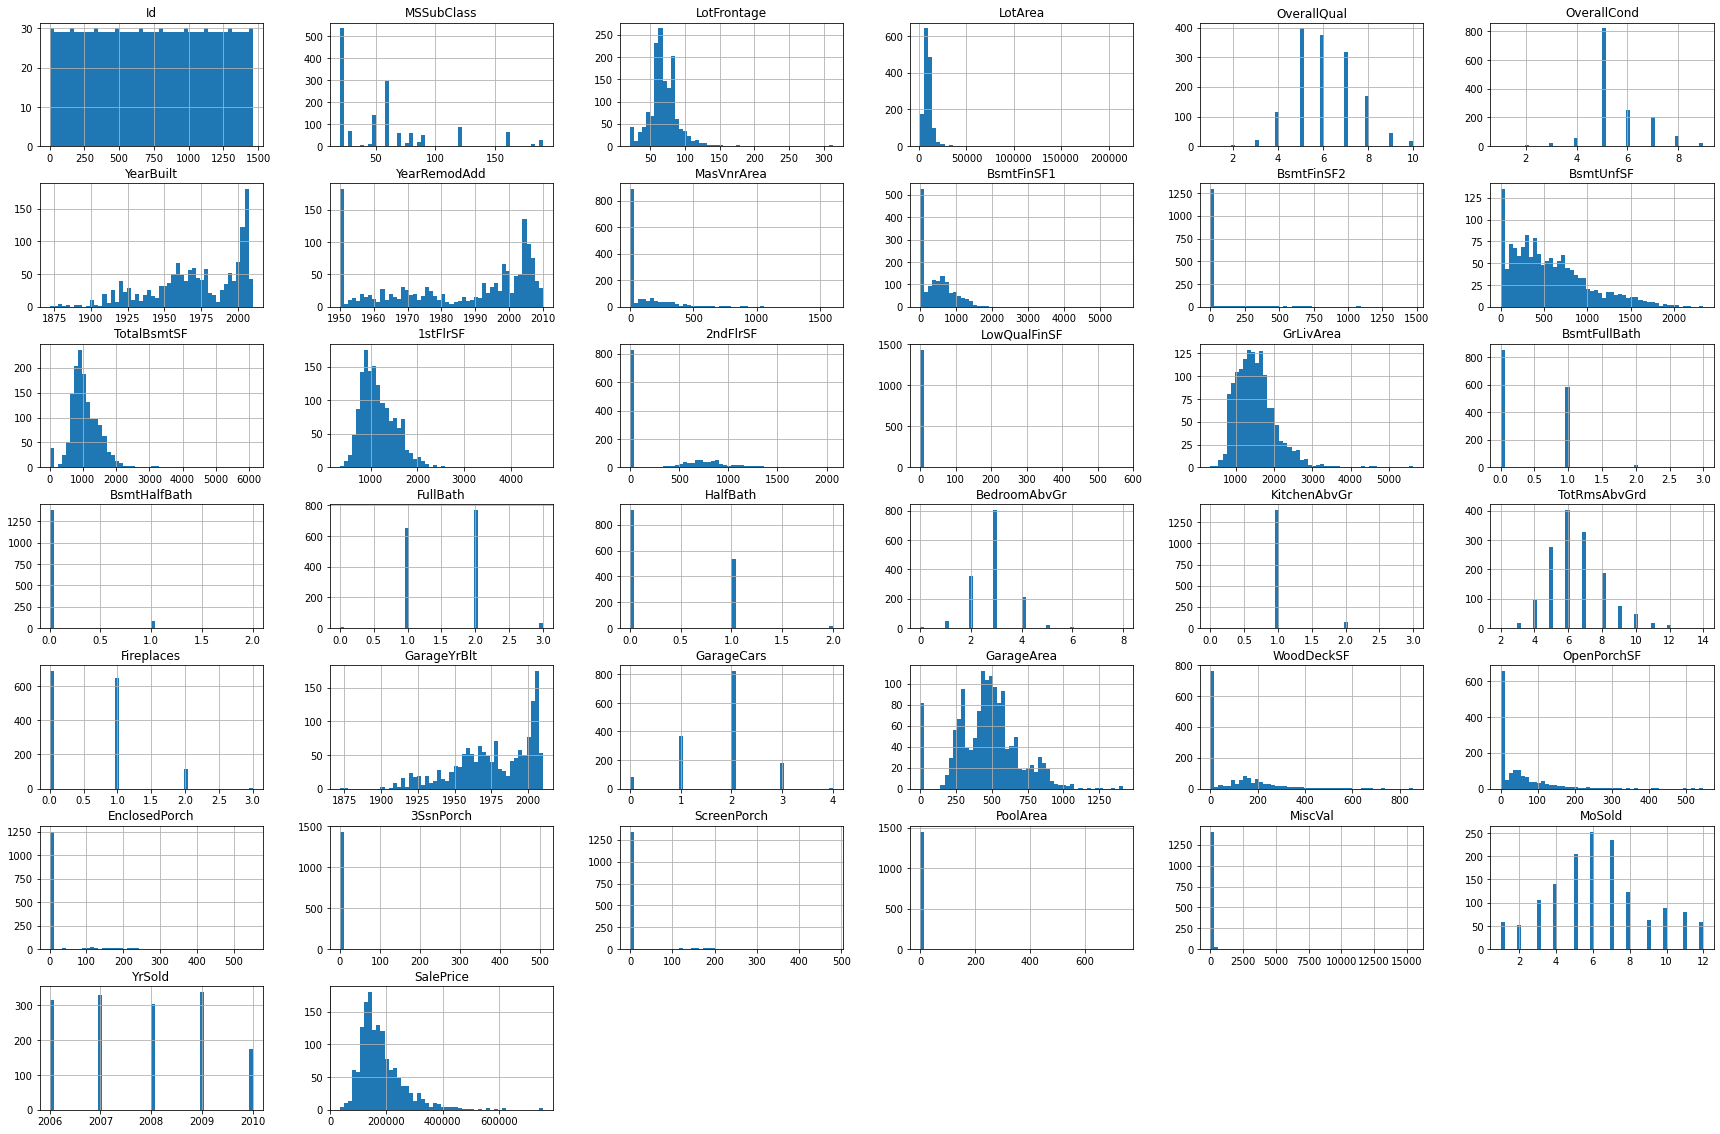

In [86]:
# Variable Distributions
df_train.hist( bins = 50, figsize = (30, 20))
plt.show()

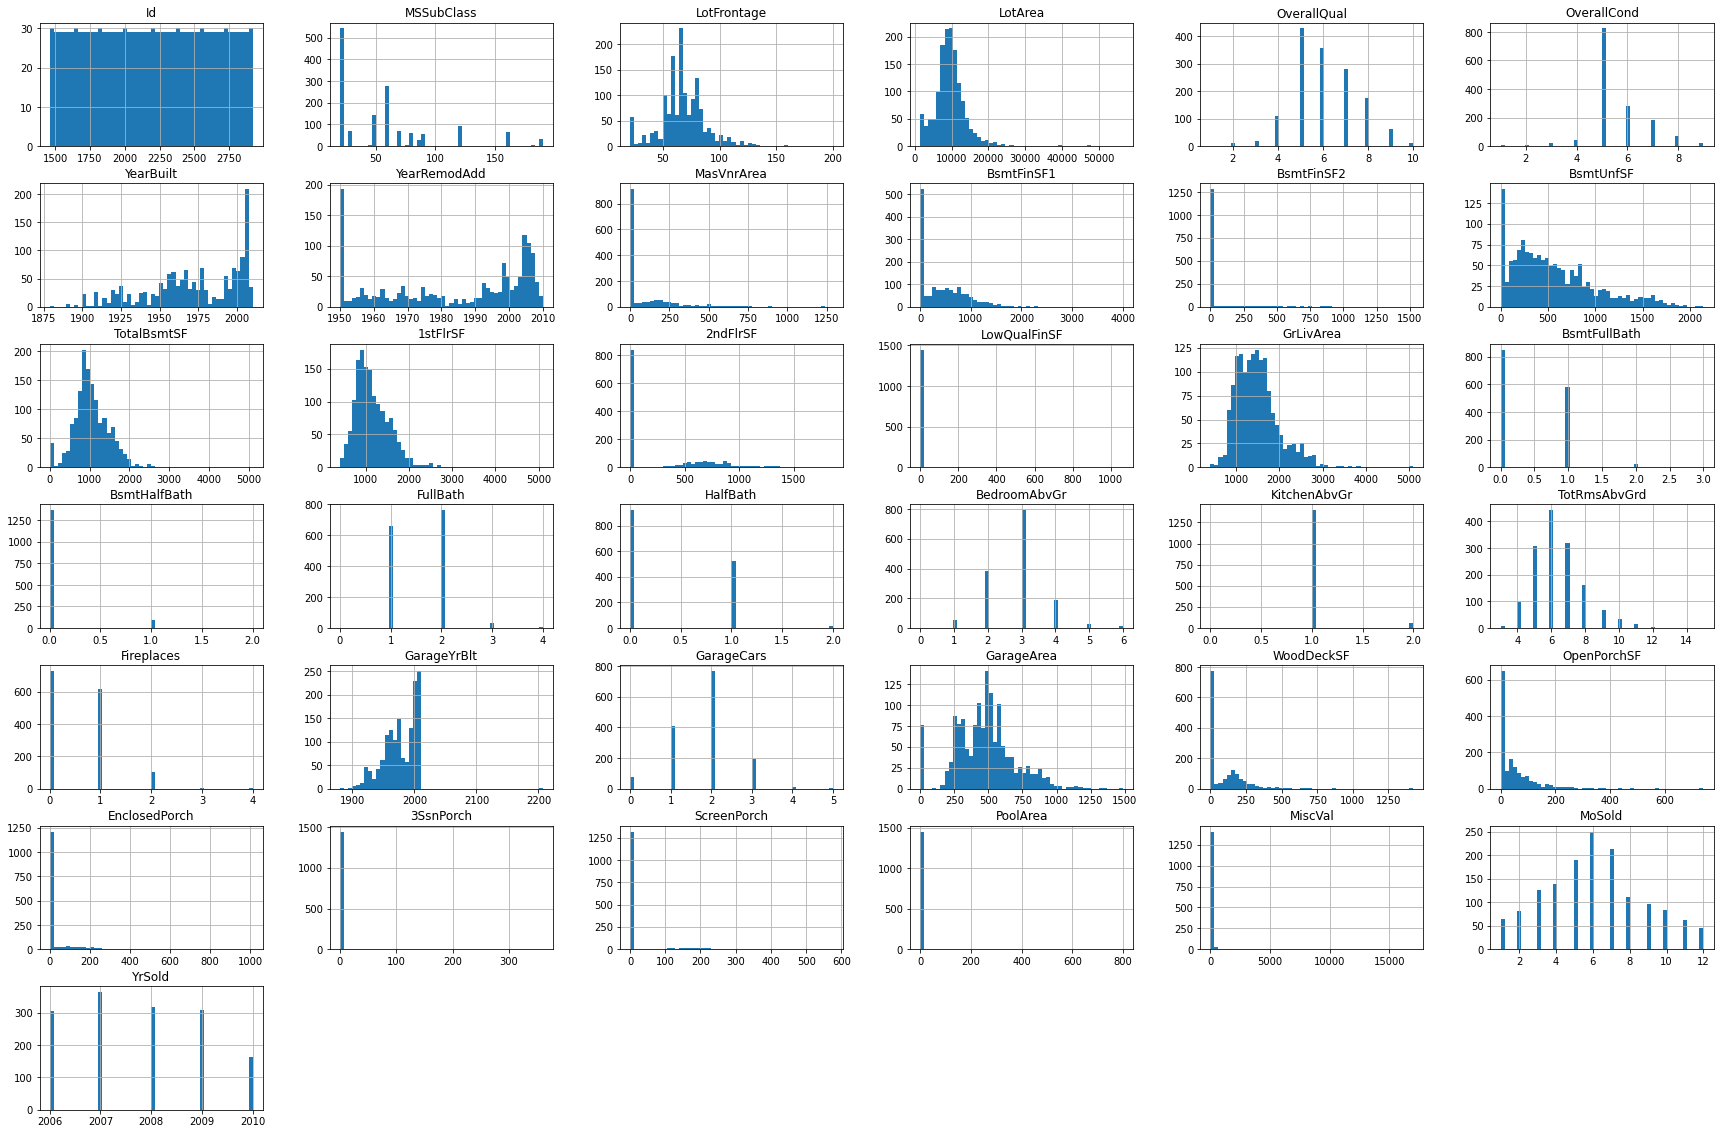

In [87]:
df_test.hist( bins = 50, figsize = (30, 20))
plt.show()

Off the bat, we can see that the distributions of the training set generally match the test set, with the exception of GarageYrBlt. It seems like there might be an outlier or more so a typo in that column within the test set that is throwing off the distribution.

In [88]:
# sorted(df_test['GarageYrBlt'].unique())

In [89]:
# It's likely the 2207 value should be 2007
index = df_test[df_test['GarageYrBlt'] == 2207].index
df_test.loc[index, 'GarageYrBlt'] = 2007

Let's take a quick look at our features to see if any contain outliers with a quick visual check.

Text(0.5, 1.0, 'All variables boxplot\n')

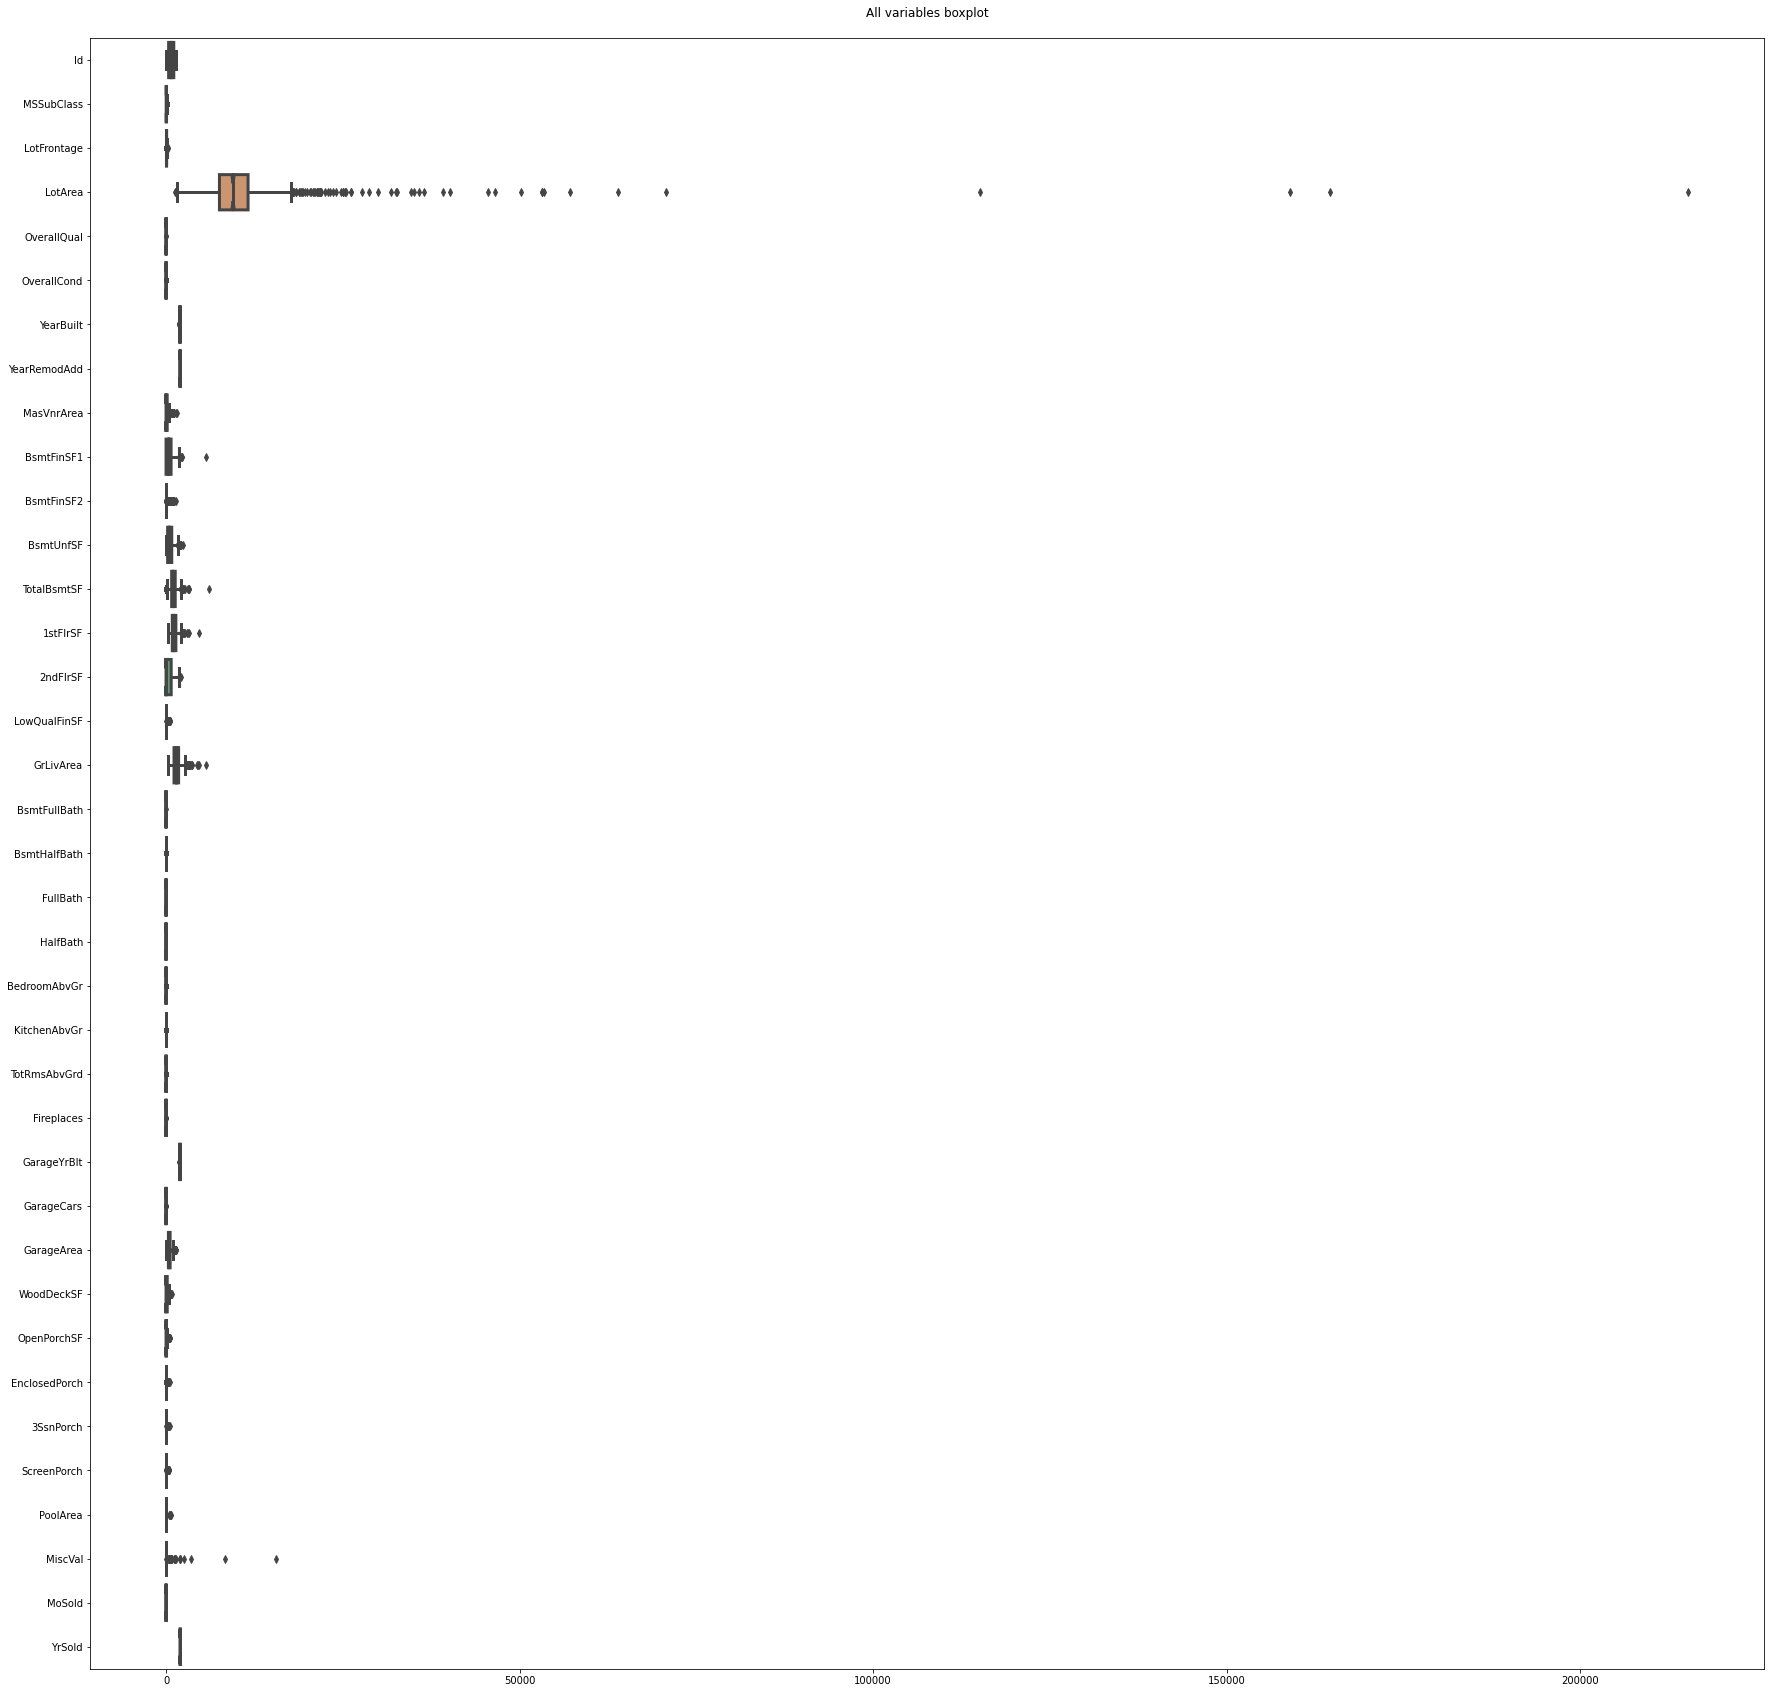

In [90]:
# Quick visual check for outliers:

fig = plt.figure(figsize=(30,30))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns != 'SalePrice'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('All variables boxplot\n')

The above chart is not very informative, but provides a decent quick glance at whether there are any outliers. This and the histogram charts above gives us a decent idea of the shape of the data.

Text(0.5, 1.0, 'Sale Price boxplot\n')

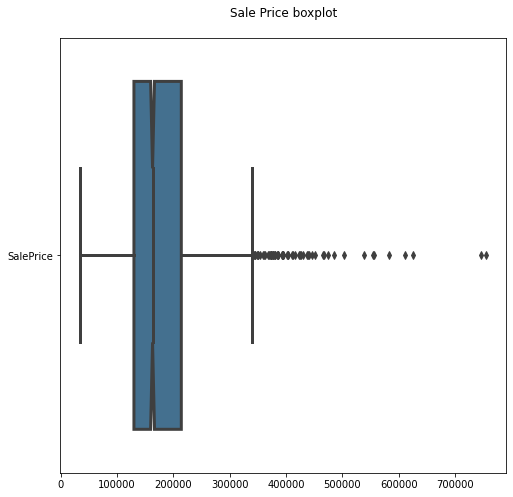

In [91]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'SalePrice'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('Sale Price boxplot\n')

Text(0.5, 1.0, 'Lot Area boxplot\n')

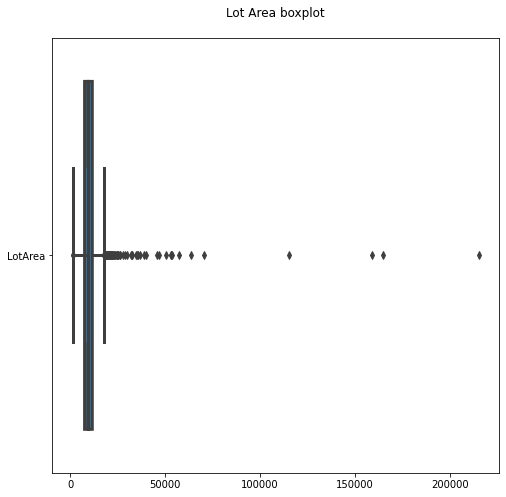

In [92]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'LotArea'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('Lot Area boxplot\n')

Text(0.5, 1.0, 'BsmtFinSF1 boxplot\n')

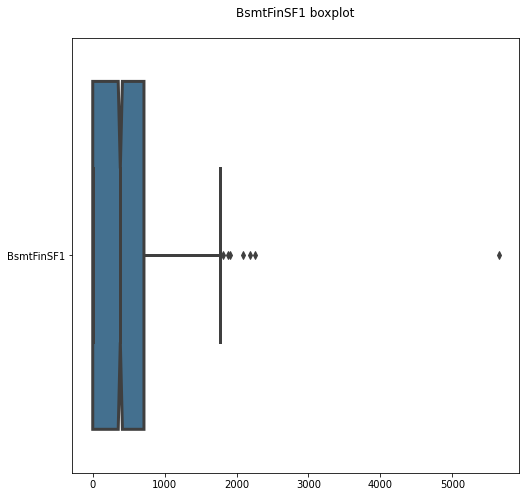

In [93]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'BsmtFinSF1'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('BsmtFinSF1 boxplot\n')

Text(0.5, 1.0, 'TotalBsmtSF boxplot\n')

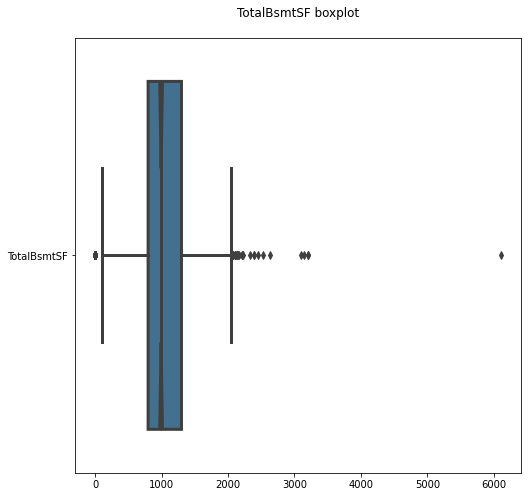

In [94]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'TotalBsmtSF'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('TotalBsmtSF boxplot\n')

Text(0.5, 1.0, '1stFlrSF boxplot\n')

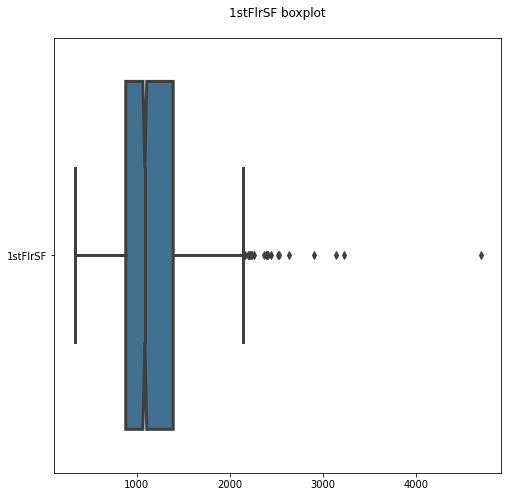

In [95]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == '1stFlrSF'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('1stFlrSF boxplot\n')

Text(0.5, 1.0, 'GrLivArea boxplot\n')

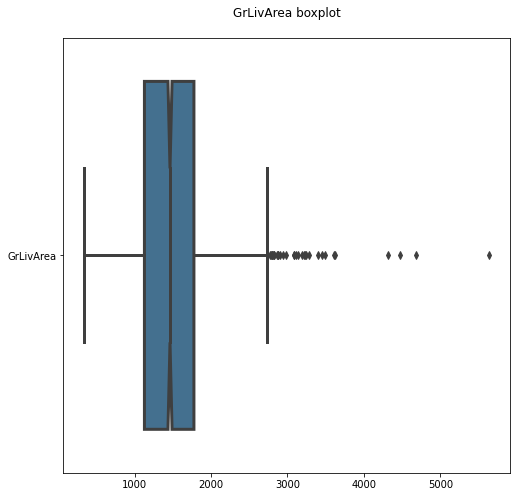

In [96]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'GrLivArea'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('GrLivArea boxplot\n')

Text(0.5, 1.0, 'MiscVal boxplot\n')

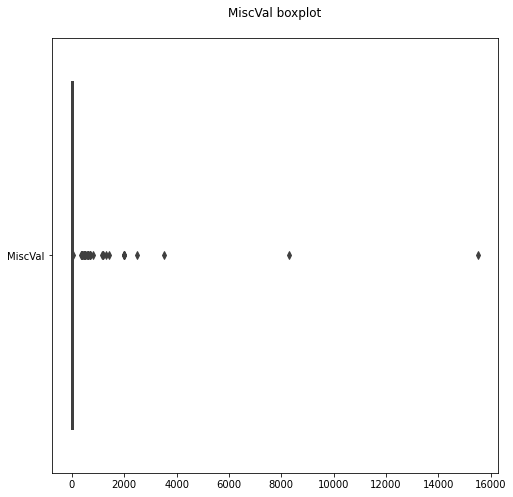

In [97]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'MiscVal'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('MiscVal boxplot\n')

Text(0.5, 1.0, 'MasVnrArea boxplot\n')

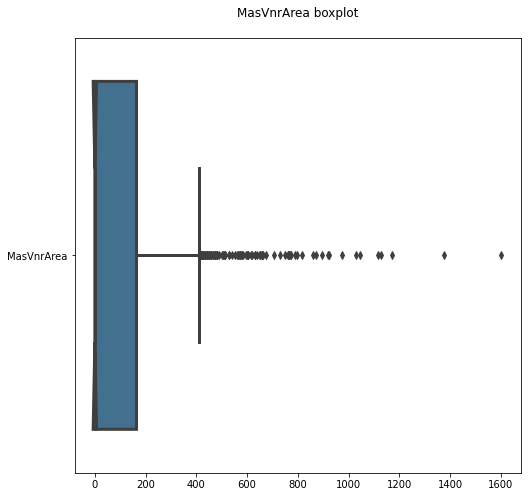

In [98]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'MasVnrArea'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('MasVnrArea boxplot\n')

Based off of the above boxplots it is hard to determine if these outliers are valid on their own. Let's plot them out against SalePrice to see if they make sense (e.g. a larger house would likely also have a higher sale price in a given area). It would also make sense to take a look at these broken down by neighborhood to help identify other anomalies, the idea being a sensible value in one neighborhood might not be the case for a different one.

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


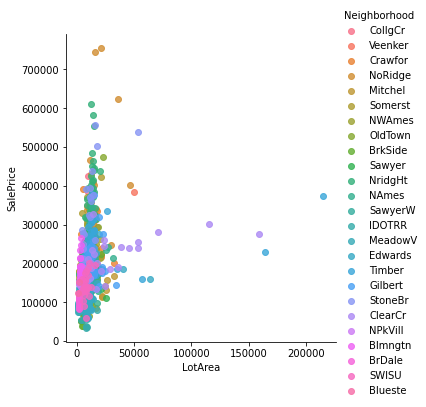

In [99]:
sns.lmplot('LotArea', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False);

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


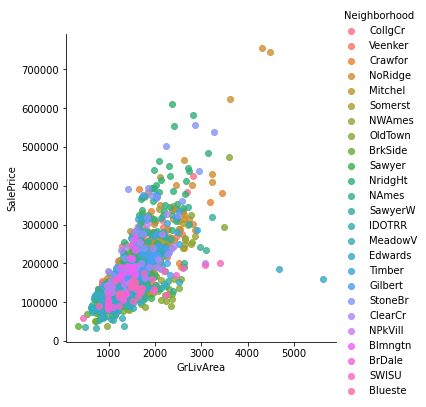

In [100]:
sns.lmplot('GrLivArea', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False);

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


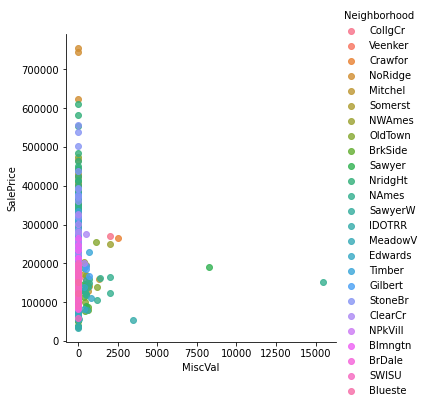

In [101]:
sns.lmplot('MiscVal', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False);

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


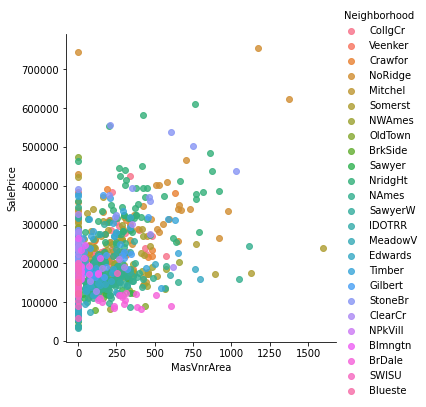

In [102]:
sns.lmplot('MasVnrArea', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False);

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


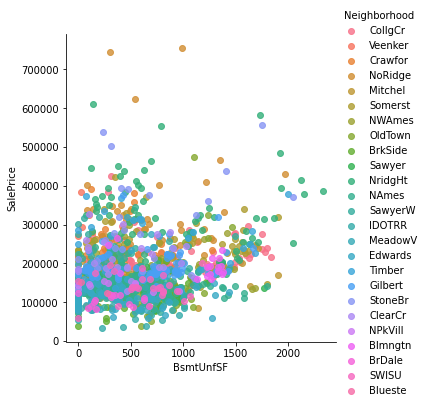

In [103]:
sns.lmplot('BsmtUnfSF', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False);

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


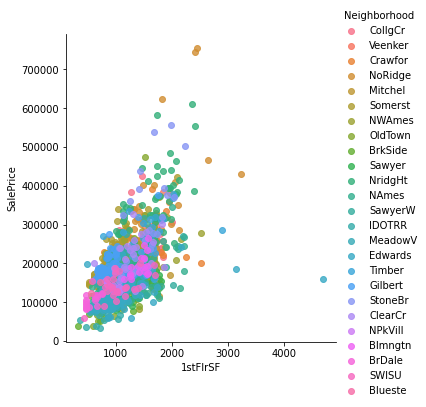

In [104]:
sns.lmplot('1stFlrSF', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False);

Let's see what happens when we remove some of the outliers:

In [105]:
df_train = df_train.drop(df_train[df_train['LotArea'] > 100000].index)
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 200000)].index)
df_train = df_train.drop(df_train[df_train['GrLivArea'] > 4000].index)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


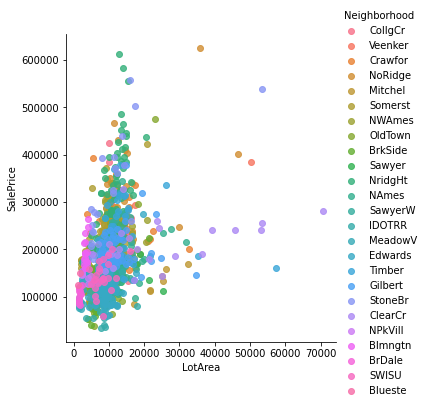

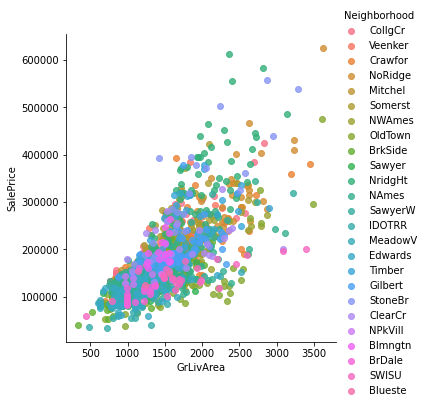

In [106]:
sns.lmplot('LotArea', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False)
sns.lmplot('GrLivArea', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False)

From the above scatter plot, it's pretty clear that square footage would be a good predictor for price.
In addition to this, it makes intuitive sense that the overall quality of the home, and the neighborhood would be good predictors of housing price.

Text(0.5, 1.0, 'OverallQual by SalePrice boxplot\n')

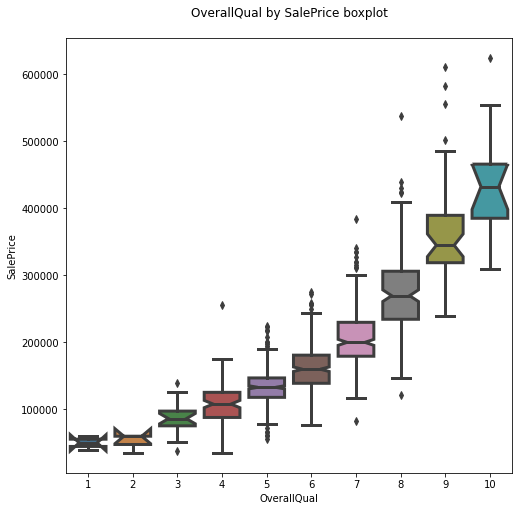

In [107]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax = sns.boxplot(x ='OverallQual', y ='SalePrice', data = df_train, fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('OverallQual by SalePrice boxplot\n')

In [108]:
neigh_order = df_train.groupby('Neighborhood')['SalePrice'].mean().to_frame().sort_values('SalePrice',ascending=True)

Text(0.5, 1.0, 'Neighborhood by SalePrice boxplot\n')

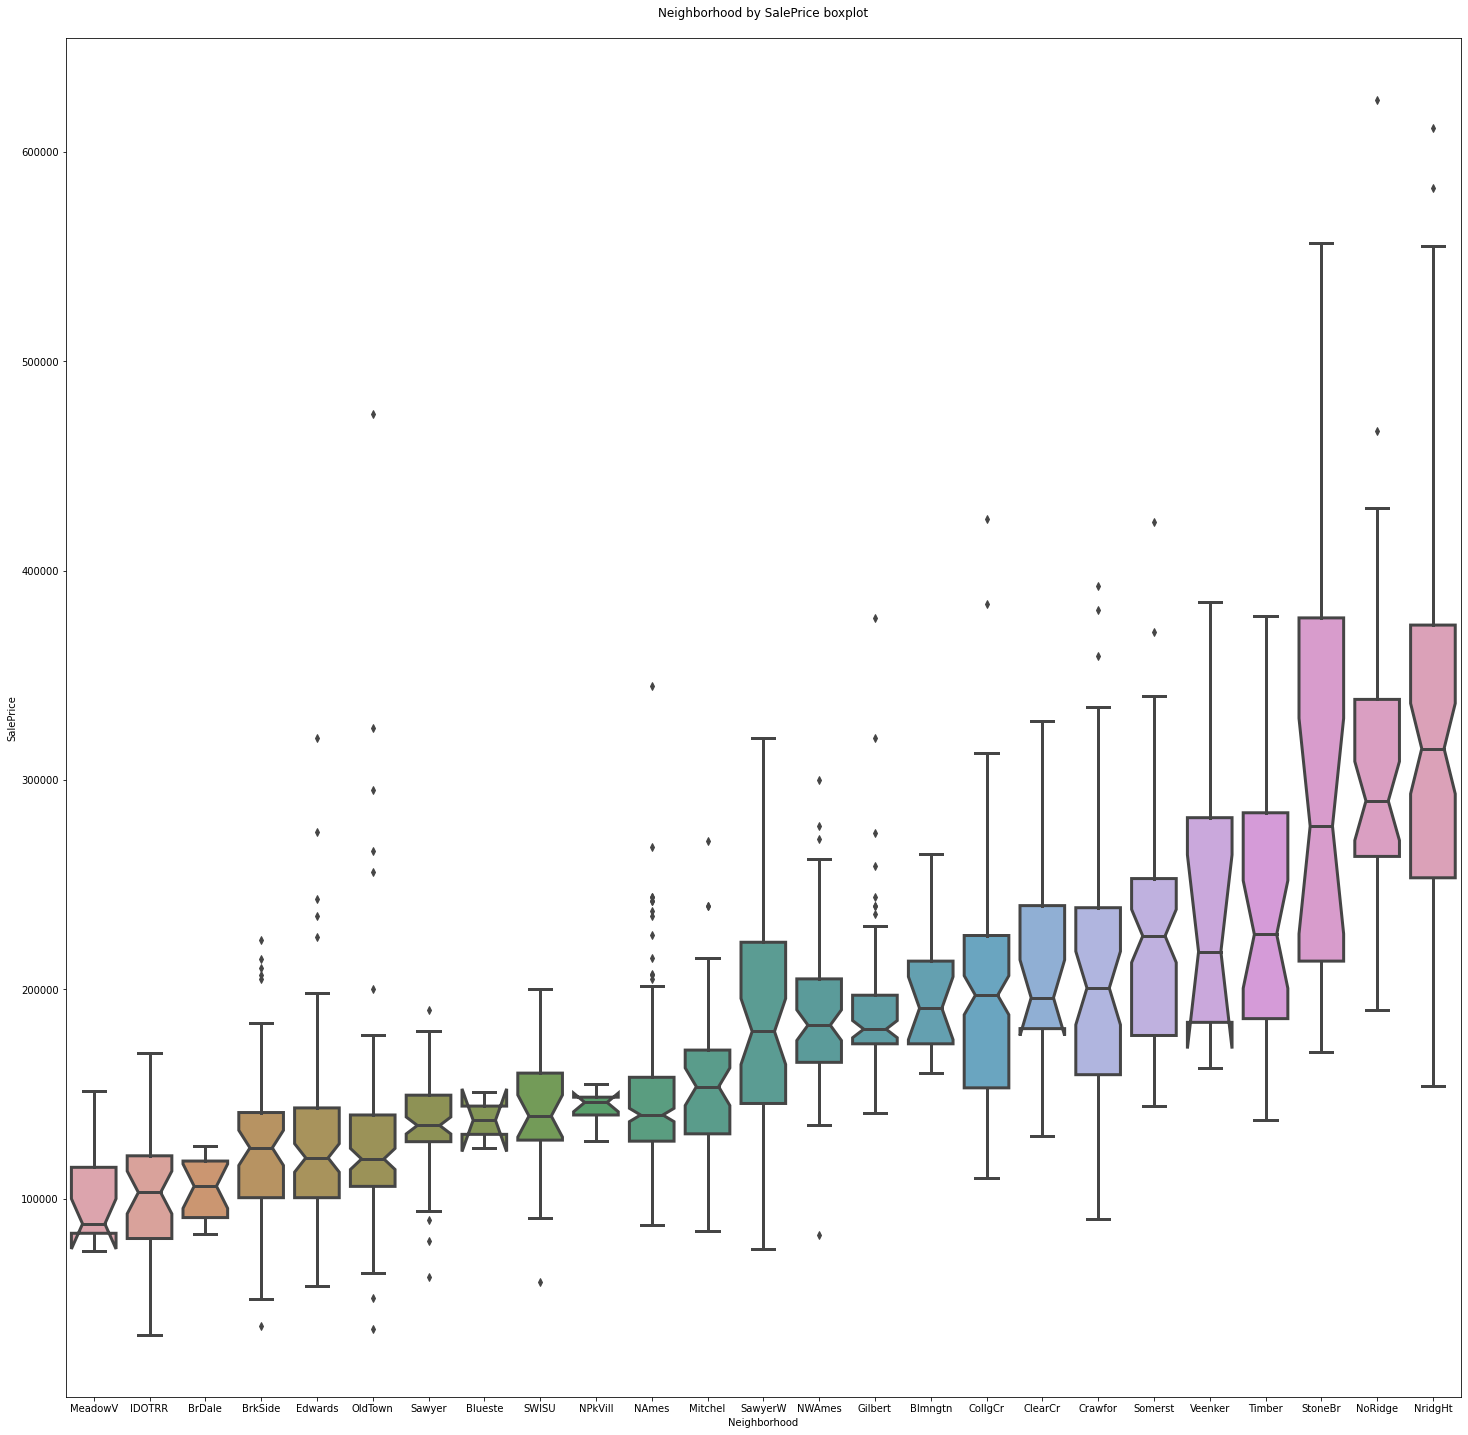

In [109]:
fig = plt.figure(figsize=(25,25))
ax = fig.gca()
ax = sns.boxplot(x ='Neighborhood', y ='SalePrice', data = df_train, fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax, order=neigh_order.index)
ax.set_title('Neighborhood by SalePrice boxplot\n')

It does seem as though OverallQual is a good potential predictor, but does not seem like Neighborhood is a good one. It intuitively makes sense that the neighborhood/location would affect the price, but there is a decent amount of variance in each, which may not make it a good indicator.

Let's take a look at correlations with SalePrice

Text(0.5, 1.0, 'Top Features by Correlation\n')

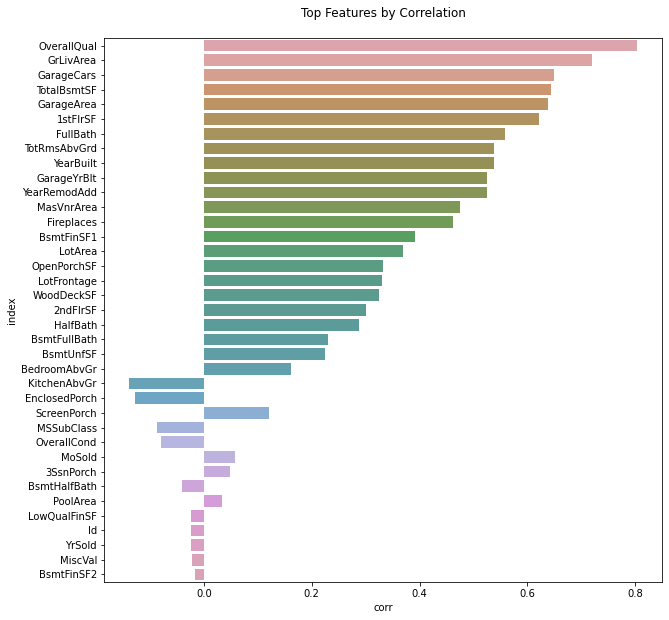

In [110]:
corr = df_train.corr()['SalePrice'].sort_values(ascending=False).to_frame(name='corr').reset_index()
# Accounting for absolute value
corr_abs = corr.reindex(corr['corr'].abs().sort_values(ascending=False).index)
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax = sns.barplot(x='corr', y='index', data=corr_abs.drop(0), saturation=0.5, ax=ax)
ax.set_title('Top Features by Correlation\n')


In [111]:
corr[1:].head(10)

index      corr
1    OverallQual  0.802832
2      GrLivArea  0.720183
3     GarageCars  0.650498
4    TotalBsmtSF  0.643992
5     GarageArea  0.638284
6       1stFlrSF  0.622602
7       FullBath  0.558330
8   TotRmsAbvGrd  0.538858
9      YearBuilt  0.538204
10   GarageYrBlt  0.524572

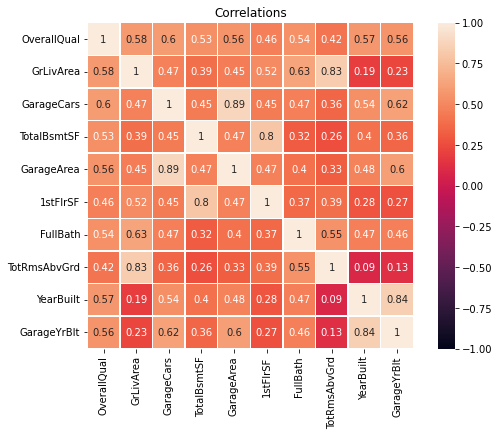

In [112]:
columns = [i for i in corr[1:]['index'].head(10)]
df_train_corr = df_train[columns]
df_train_corr.corr()

corrmat = df_train_corr.corr()

f, ax = plt.subplots(figsize = (9,6))
sns.heatmap(corrmat, vmin = -1, vmax = 1, square=True, annot = True, linewidths =.5)
plt.title('Correlations')

plt.show()

Based off the correlations of the top 10 features above, it seems as though there are some collinearity between features such as the area/square footage features. Because of this, it might be imperative to combine features together to reduce multicollinearity among predictors.

#### **Transformation**

##### Feature Engineering

Since this dataset contains these factors broken out into smaller sub features, we can potentially combine a few together to create new features such as total square footage. We can also transform the quality features into ordinal variables, potentially making it easier to perform a regression, instead of creating dummy variables for them.

In [113]:
# Combine SF features to create Total SF
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']
# Combine Bathroom features to create Total Baths
df_train['TotalBaths'] = df_train['FullBath'] + df_train['BsmtFullBath'] + 0.5*(df_train['HalfBath'] + df_train['BsmtHalfBath'])
df_test['TotalBaths'] = df_test['FullBath'] + df_test['BsmtFullBath'] + 0.5*(df_test['HalfBath'] + df_test['BsmtHalfBath'])

In [114]:
# Rating Dictionary
rating_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}

# Find all columns that use rating system: Ex, Gd, TA, Fa, Po
rating_columns = [col for col in df_train.columns if df_train[col].sort_values().iloc[0] == 'Ex']
rating_columns.append('BsmtCond')

# # Map values using dictionary
for col in rating_columns:
    df_train[col] = df_train[col].map(rating_dict)
    df_test[col] = df_test[col].map(rating_dict)

In [115]:
# Make sure train and test set contains all values of neighborhoods

neighborhoods_train = list(df_train['Neighborhood'].unique())
neighborhoods_test = list(df_test['Neighborhood'].unique())
neighborhoods_comb = set(neighborhoods_train + neighborhoods_test)
neighborhoods_left = list(set(neighborhoods_comb) - set(neighborhoods_train))
neighborhoods_left

[]

In [116]:
neighborhood = neigh_order.reset_index()
neighborhood['neighborhoodcat'] = pd.qcut(neighborhood['SalePrice'], q=4, labels=False).to_frame(name='cat')

In [117]:
df_train = df_train.merge(neighborhood[['Neighborhood', 'neighborhoodcat']], on='Neighborhood')
df_test = df_test.merge(neighborhood[['Neighborhood', 'neighborhoodcat']], on='Neighborhood')

Text(0.5, 1.0, 'NeighborhoodCat by SalePrice boxplot\n')

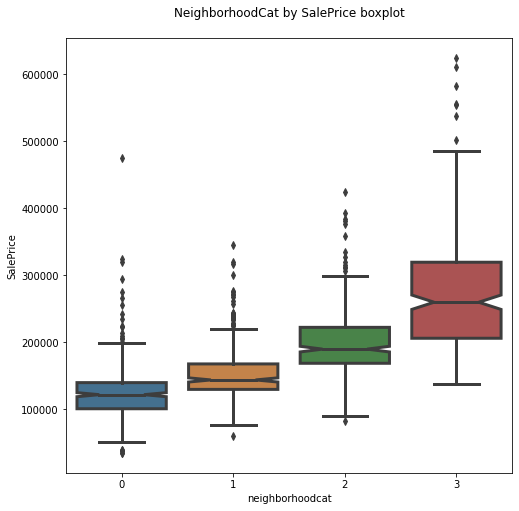

In [118]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax = sns.boxplot(x ='neighborhoodcat', y ='SalePrice', data = df_train, fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('NeighborhoodCat by SalePrice boxplot\n')

After breaking Neighborhoods into the different buckets, it still looks like there is some variance in each bucket, but it looks to be a viable option.

In [119]:
corr = df_train.corr()['SalePrice'].sort_values(ascending=False).to_frame(name='corr').reset_index()
corr_abs = corr.reindex(corr['corr'].abs().sort_values(ascending=False).index)
corr_abs[1:].head(10)

index      corr
1           TotalSF  0.824013
2       OverallQual  0.802832
3         GrLivArea  0.720183
4         ExterQual  0.699219
5   neighborhoodcat  0.673850
6       KitchenQual  0.669496
7        GarageCars  0.650498
8       TotalBsmtSF  0.643992
9        GarageArea  0.638284
10       TotalBaths  0.634424

##### Interaction Terms

TotalSF - OverallQual Interaction Term

In [120]:
model = smf.ols(formula='SalePrice ~ TotalSF + OverallQual', data=df_train).fit()
summary = model.summary()
summary.tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [121]:
print(model.rsquared)

0.7906531677895561


In [122]:
model = smf.ols(formula='SalePrice ~ TotalSF + OverallQual + TotalSF:OverallQual', data=df_train).fit()
summary = model.summary()
summary.tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [123]:
print(model.rsquared)

0.8435085256253119


TotalSF - neighborhoodcat Interaction Term

In [124]:
model = smf.ols(formula='SalePrice ~ TotalSF + neighborhoodcat', data=df_train).fit()
summary = model.summary()
summary.tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [125]:
print(model.rsquared)

0.7605749811850429


In [126]:
model = smf.ols(formula='SalePrice ~ TotalSF + OverallQual + TotalSF:neighborhoodcat', data=df_train).fit()
summary = model.summary()
summary.tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [127]:
print(model.rsquared)

0.8278318501009048


In [128]:
# Create new features based on interaction term
df_train['TotalSF*OverallQual'] = df_train['TotalSF'] * df_train['OverallQual']
df_test['TotalSF*OverallQual'] = df_test['TotalSF'] * df_test['OverallQual']

##### Dummy Variables

In [129]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [130]:
dummies = ['Neighborhood', 'neighborhoodcat', 'MSZoning', 'MSSubClass', 'Street', 'LotShape', 'LotConfig',
           'Utilities', 'LandSlope', 'BldgType', 'HouseStyle', 'RoofStyle', 'Foundation', 'Heating', 'CentralAir',
           'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'LandContour', 'FireplaceQu', 'PoolQC',
           'Alley', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'TotRmsAbvGrd'
           ]

In [131]:
# Ensure both train/test sets end up with identical columns if categorical values differ
for col in dummies:
    train = sorted(df_train[col].unique().tolist())
    test = sorted(df_test[col].unique().tolist())
    total = set(train + test)
    df_train[col] = pd.Categorical(df_train[col], categories=total)
    df_test[col] = pd.Categorical(df_test[col], categories=total)


# Create dummy vars for train/test sets.
# drop_first=True since we only need k-1 cols
df_train = pd.get_dummies(df_train, columns=dummies, drop_first=True)
df_test = pd.get_dummies(df_test, columns=dummies, drop_first=True)

In [132]:
df_train.head()

Id  LotFrontage  LotArea  ... TotRmsAbvGrd_13 TotRmsAbvGrd_14  TotRmsAbvGrd_15
0   1         65.0     8450  ...               0               0                0
1   3         68.0    11250  ...               0               0                0
2  14         91.0    10652  ...               0               0                0
3  23         75.0     9742  ...               0               0                0
4  33         85.0    11049  ...               0               0                0

[5 rows x 216 columns]

#### **Modeling**

##### Model 1 - Simple Linear Regression
<br>
Based on the correlations above, it would make sense to create a baseline model using the top predictor: TotalSF

In [133]:
features1 = ['TotalSF']
x1 = df_train[features1]
y = df_train["SalePrice"]
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y, test_size=0.2)

In [134]:
linreg = LinearRegression()
kf = KFold(n_splits = 7, shuffle=True)

scores = cross_val_score(linreg, x1_train, y1_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.69738706 0.68171507 0.69228062 0.62180285 0.66027136 0.61923699
 0.68453686]
Mean: 0.6653186855817909 SD: 0.03032239247184424


In [135]:
linreg.fit(x1_train, y1_train)
linreg.score(x1_train, y1_train)

0.6709626985493005

In [136]:
linreg.score(x1_test, y1_test)

0.7049064877425342

Text(400000, 0, 'R2 = 0.7049064877425342')

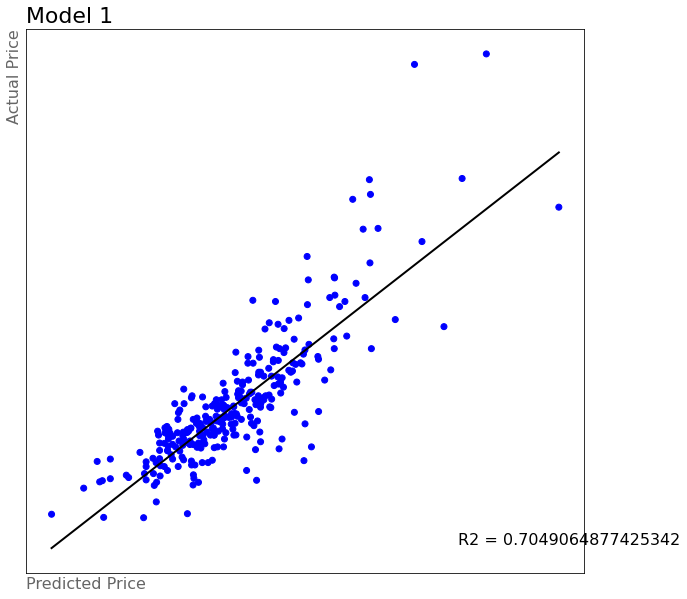

In [137]:
plt.figure(figsize=(10,10))
col = np.where(linreg.predict(x1_test) > 500000, 'r', 'b')
plt.scatter(linreg.predict(x1_test), y1_test, c=col)
plt.title('Model 1', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(linreg.predict(x1_test)), max(linreg.predict(x1_test))], [min(linreg.predict(x1_test)), max(linreg.predict(x1_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {linreg.score(x1_test, y1_test)}', size=16)


In [138]:
coef1 = linreg.coef_
header1 = x1_test.columns 
d = {'feature': header1, 'coef': coef1}
df1 = pd.DataFrame(d)
df1

feature      coef
0  TotalSF  82.60472

In simple terms, what the coefficient above is saying is that the dependent variable: SalePrice is expected to increase by ~83 with a 1 unit increase in TotalSF. 

In [139]:
# Kaggle Predictions - Model 1:
# x_holdout1 = df_test[features1]
# preds1 = linreg.predict(x_holdout1)
# submission1 = pd.DataFrame(preds1, index=df_test['Id'])
# submission1.rename(columns={0:'SalePrice'}, inplace=True)
# submission1.head()

In [140]:
# submission1.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission1.csv')

Model 1 Kaggle Score: 0.25935

##### Model 2 - Simple Linear Regression using Interaction Term

In [141]:
features2 = ['TotalSF*OverallQual']
x2 = df_train[features2]
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y, test_size=0.2)

In [142]:
linreg = LinearRegression()
kf = KFold(n_splits = 7, shuffle=True)

scores = cross_val_score(linreg, x2_train, y2_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.83908157 0.78409743 0.85552077 0.852946   0.77116674 0.84133864
 0.82919387]
Mean: 0.824763573441646 SD: 0.031089676863029304


In [143]:
linreg.fit(x2_train, y2_train)
linreg.score(x2_train, y2_train)

0.8305089339240881

In [144]:
linreg.score(x2_test, y2_test)

0.8552490032073299

Text(400000, 0, 'R2 = 0.8552490032073299')

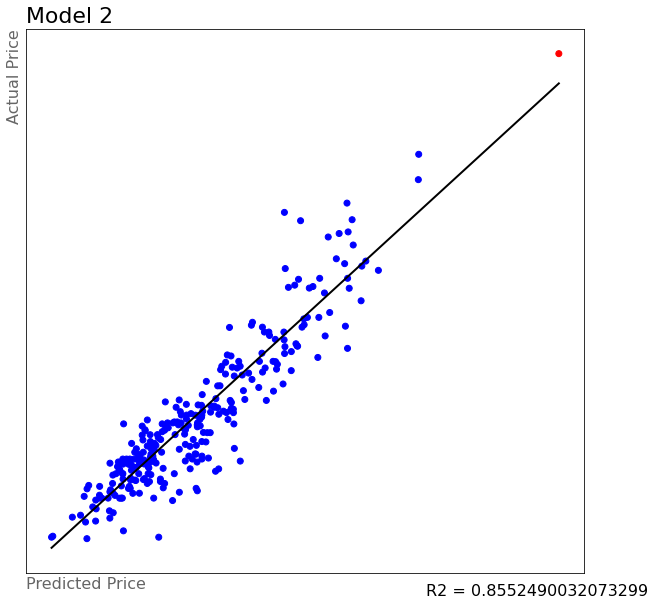

In [145]:
plt.figure(figsize=(10,10))
col = np.where(linreg.predict(x2_test) > 500000, 'r', 'b')
plt.scatter(linreg.predict(x2_test), y2_test, c=col)
plt.title('Model 2', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(linreg.predict(x2_test)), max(linreg.predict(x2_test))], [min(linreg.predict(x2_test)), max(linreg.predict(x2_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {linreg.score(x2_test, y2_test)}', size=16)

In [146]:
coef2 = linreg.coef_
header2 = x2_test.columns 
d = {'feature': header2, 'coef': coef2}
df2 = pd.DataFrame(d)
df2

feature      coef
0  TotalSF*OverallQual  8.885385

Similar to model 1, what the coefficient above is saying is that the SalePrice is expected to increase by ~9 with a 1 unit increase in the interaction term of TotalSF and OverallQual.

In [147]:
# Kaggle Predictions - Model 2:
# x_holdout2 = df_test[features2]
# preds2 = linreg.predict(x_holdout2)
# submission2 = pd.DataFrame(preds2, index=df_test['Id'])
# submission2.rename(columns={0:'SalePrice'}, inplace=True)
# submission2.head()

In [148]:
# submission2.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission2.csv')

Model 2 Kaggle Score: 0.18368

##### Model 3 - Multiple Linear Regression

(TotalSF*OverallQual, KitchenQual, GarageCars, and TotalBaths)

In [149]:
features3 = ['TotalSF*OverallQual', 'KitchenQual', 'GarageCars', 'TotalBaths']
x3 = df_train[features3]
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y, test_size=0.2)

In [150]:
linreg = LinearRegression()
kf = KFold(n_splits = 7, shuffle=True)

scores = cross_val_score(linreg, x3_train, y3_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.86181636 0.85303071 0.86840015 0.84007119 0.85797752 0.89662317
 0.84266182]
Mean: 0.8600829883592891 SD: 0.017588557211085022


In [151]:
linreg.fit(x3_train, y3_train)
linreg.score(x3_train, y3_train)

0.8640565985722697

In [152]:
linreg.score(x3_test, y3_test)

0.8563634278271108

Text(400000, 0, 'R2 = 0.8563634278271108')

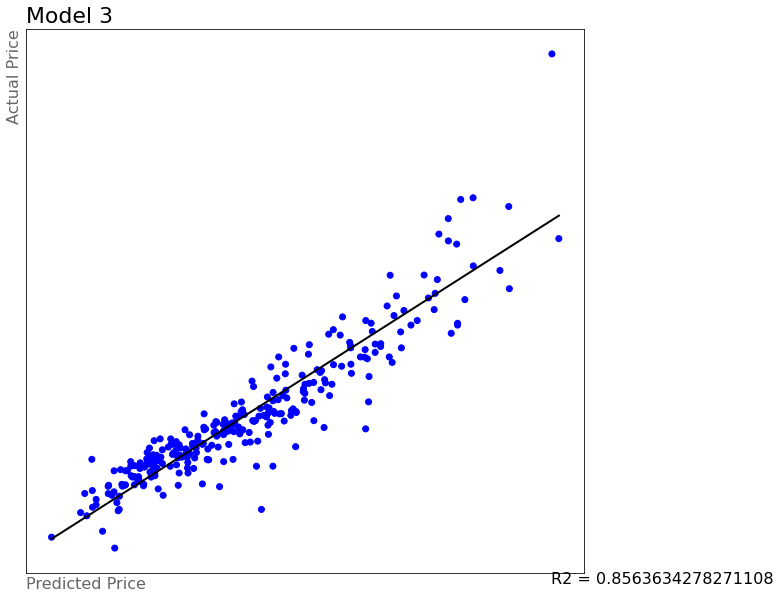

In [153]:
plt.figure(figsize=(10,10))
col = np.where(linreg.predict(x3_test) > 500000, 'r', 'b')
plt.scatter(linreg.predict(x3_test), y3_test, c=col)
plt.title('Model 3', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(linreg.predict(x3_test)), max(linreg.predict(x3_test))], [min(linreg.predict(x3_test)), max(linreg.predict(x3_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {linreg.score(x3_test, y3_test)}', size=16)

In [154]:
coef3 = linreg.coef_
header3 = x3_test.columns 
d = {'feature': header3, 'coef': coef3}
df3 = pd.DataFrame(d)
df3

feature          coef
0  TotalSF*OverallQual      7.030796
1          KitchenQual  13599.427698
2           GarageCars   9995.846262
3           TotalBaths  10347.798182

Since model 3 is utilizing multiple linear regression, the interpretation of the coefficients is slightly different than with simple linear regression. The coefficients for each feature refers to the amount the SalePrice would increase with a 1 unit increase of that variable while holding the other independent variables constant. For example, SalePrice increases by 7 units with a 1 unit increase in the interaction term TotalSF*OverallQual given the other independent variable remain constant.

In [155]:
# Kaggle Predictions - Model 3:
# x_holdout3 = df_test[features3]
# preds3 = linreg.predict(x_holdout3)
# submission3 = pd.DataFrame(preds3, index=df_test['Id'])
# submission3.rename(columns={0:'SalePrice'}, inplace=True)
# submission3.head()

In [156]:
# submission3.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission3.csv')

Model 3 Kaggle Score: 0.17248

Model 3: Scaled

In [157]:
scaler = StandardScaler()
x3_scaled_train = scaler.fit_transform(x3_train)
x3_scaled_test = scaler.transform(x3_test)

linreg = LinearRegression()
kf = KFold(n_splits = 7, shuffle=True)

scores = cross_val_score(linreg, x3_scaled_train, y3_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.83675223 0.88012609 0.82399291 0.89615327 0.86277555 0.86130088
 0.83540839]
Mean: 0.8566441885288961 SD: 0.02415545266857075


In [158]:
linreg.fit(x3_scaled_train, y3_train)
linreg.score(x3_scaled_train, y3_train)

0.8640565985722697

In [159]:
linreg.score(x3_scaled_test, y3_test)

0.8563634278271108

Text(400000, 0, 'R2 = 0.8563634278271108')

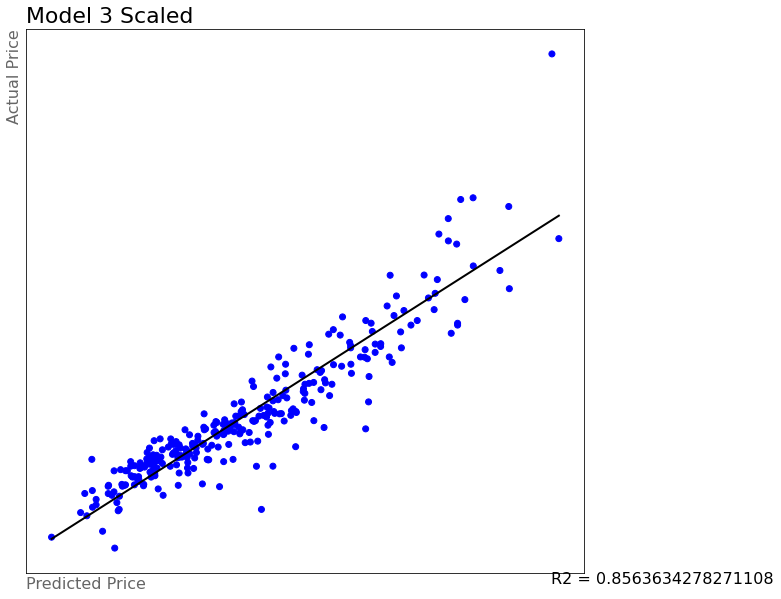

In [160]:
plt.figure(figsize=(10,10))
col = np.where(linreg.predict(x3_scaled_test) > 500000, 'r', 'b')
plt.scatter(linreg.predict(x3_scaled_test), y3_test, c=col)
plt.title('Model 3 Scaled', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(linreg.predict(x3_scaled_test)), max(linreg.predict(x3_scaled_test))], [min(linreg.predict(x3_scaled_test)), max(linreg.predict(x3_scaled_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {linreg.score(x3_scaled_test, y3_test)}', size=16)

In [161]:
coef3 = linreg.coef_
header3 = x3_test.columns 
d = {'feature': header3, 'coef': coef3}
df3 = pd.DataFrame(d)
df3

feature          coef
0  TotalSF*OverallQual  55350.453508
1          KitchenQual   8908.658592
2           GarageCars   7579.654447
3           TotalBaths   8026.756344

Although scaling the data for linear regression doesn't seem to affect the r-squared too much, it does seem to scale the coefficients so that they are all using the same units which makes it easier to explain and interpret, especially if fitting a multiple linear regression.

In [162]:
# Kaggle Predictions - Model 3 Scaled:
# x_holdout3 = df_test[features3]
# x_scaled_holdout3 = scaler.transform(x_holdout3)
# preds3 = linreg.predict(x_scaled_holdout3)
# submission3_scaled = pd.DataFrame(preds3, index=df_test['Id'])
# submission3_scaled.rename(columns={0:'SalePrice'}, inplace=True)
# submission3_scaled.head()

In [163]:
# submission3_scaled.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission3_scaled.csv')

Model 3 Scaled Kaggle Score: 0.16913

##### Model 4 - Multiple Linear Regression with Dummy Variables

In [164]:
neighborhood_dummy = [col for col in df_train if 'Neighborhood_' in col]
features_4_1 = ['TotalSF*OverallQual', 'KitchenQual', 'GarageCars', 'TotalBaths']
features4 = features_4_1 + neighborhood_dummy 
x4 = df_train[features4]
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y, test_size=0.2)

In [165]:
scaler = StandardScaler()
x4_scaled_train = scaler.fit_transform(x4_train)
x4_scaled_test = scaler.transform(x4_test)

linreg = LinearRegression()
kf = KFold(n_splits = 7, shuffle=True)

scores = cross_val_score(linreg, x4_scaled_train, y4_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.89302584 0.87347131 0.87593374 0.85571888 0.87384204 0.87994366
 0.86754869]
Mean: 0.8742120232651872 SD: 0.010534689934133885


In [166]:
linreg.fit(x4_scaled_train, y4_train)
linreg.score(x4_scaled_train, y4_train)

0.8822943196879854

In [167]:
linreg.score(x4_scaled_test, y4_test)

0.871116475690774

Text(400000, 0, 'R2 = 0.871116475690774')

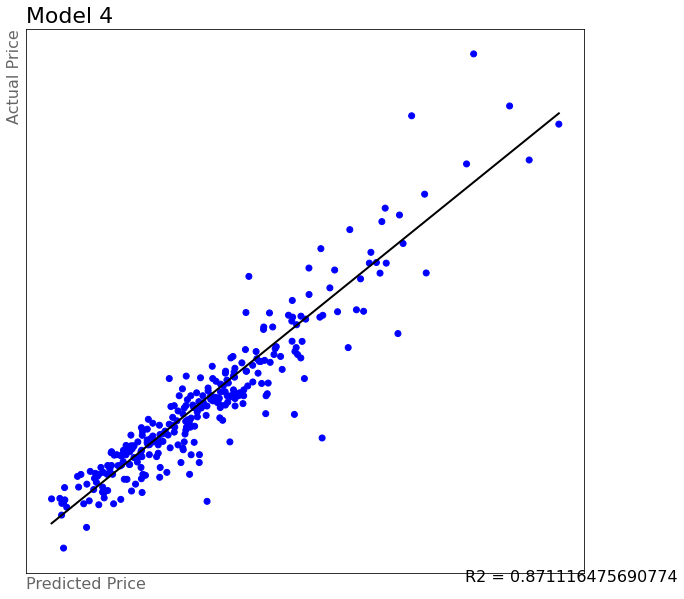

In [168]:
plt.figure(figsize=(10,10))
col = np.where(linreg.predict(x4_scaled_test) > 500000, 'r', 'b')
plt.scatter(linreg.predict(x4_scaled_test), y4_test, c=col)
plt.title('Model 4', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(linreg.predict(x4_scaled_test)), max(linreg.predict(x4_scaled_test))], [min(linreg.predict(x4_scaled_test)), max(linreg.predict(x4_scaled_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {linreg.score(x4_scaled_test, y4_test)}', size=16)

In [169]:
coef4 = linreg.coef_
header4 = x4_test.columns 
d = {'feature': header4, 'coef': coef4}
df4 = pd.DataFrame(d)
df4

feature          coef
0    TotalSF*OverallQual  50757.305837
1            KitchenQual   7735.686677
2             GarageCars   6288.001425
3             TotalBaths   6092.024697
4     Neighborhood_SWISU  -1514.788054
5   Neighborhood_SawyerW   -885.216659
6   Neighborhood_Veenker   2176.897431
7    Neighborhood_Sawyer    213.633486
8   Neighborhood_StoneBr   4110.692733
9    Neighborhood_NWAmes  -1861.210095
10  Neighborhood_Blmngtn  -2268.904337
11  Neighborhood_NridgHt   5881.589070
12  Neighborhood_MeadowV  -1698.505904
13  Neighborhood_OldTown  -5082.141233
14   Neighborhood_BrDale  -2157.837932
15  Neighborhood_NoRidge   3640.389761
16  Neighborhood_ClearCr   2691.618786
17  Neighborhood_Edwards  -1067.549984
18    Neighborhood_NAmes  -1600.340424
19   Neighborhood_Timber    573.678929
20  Neighborhood_Gilbert    720.931180
21  Neighborhood_Blueste   -631.691122
22  Neighborhood_NPkVill  -1124.254467
23  Neighborhood_Crawfor   2875.014404
24  Neighborhood_Mitchel   -321.790332
25  Neighborhood_CollgCr     60.716810
26   Neighborhood_IDOTRR  -1984.719623
27  Neighborhood_Somerst   1428.727493

Model 4 is essentially the same as model 3, with additional variables, therefore the interpretation of the coefficients is the same. Because of the added dummy variables for neighborhood, the effect of the interaction term decreases from the previous model.

In [170]:
# Kaggle Predictions - Model 4:
# x_holdout4 = df_test[features4]
# x_scaled_holdout4 = scaler.transform(x_holdout4)
# preds4 = linreg.predict(x_scaled_holdout4)
# submission4 = pd.DataFrame(preds4, index=df_test['Id'])
# submission4.rename(columns={0:'SalePrice'}, inplace=True)
# submission4.head()

In [171]:
# submission4.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission4_scaled.csv')

Model 4 Kaggle Score: 0.16689
Scaled: 0.16296

##### Model 5 - Multiple Linear Regression with Dummy Variables Part II

Adding in external variables.

In [172]:
features_5_1 = features4 
sale_cond = [col for col in df_train if 'SaleCondition_' in col]
sale_type = [col for col in df_train if 'SaleType_' in col]
sale_mo = [col for col in df_train if 'MoSold_' in col]
sale_yr = [col for col in df_train if 'YrSold_' in col]

features5 = features_5_1 + sale_cond + sale_type + sale_mo + sale_yr 
x5 = df_train[features5]
x5_train, x5_test, y5_train, y5_test = train_test_split(x5, y, test_size=0.2)

In [173]:
scaler = StandardScaler()
x5_scaled_train = scaler.fit_transform(x5_train)
x5_scaled_test = scaler.transform(x5_test)

linreg = LinearRegression()
kf = KFold(n_splits = 7, shuffle=True)

scores = cross_val_score(linreg, x5_scaled_train, y5_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.88880444 0.87492393 0.89342969 0.82277808 0.84241018 0.87238339
 0.88324882]
Mean: 0.8682826464512299 SD: 0.02413792806249989


In [174]:
linreg.fit(x5_scaled_train, y5_train)
linreg.score(x5_scaled_train, y5_train)

0.890501336121274

In [175]:
linreg.score(x5_scaled_test, y5_test)

0.880762697191646

Text(400000, 0, 'R2 = 0.880762697191646')

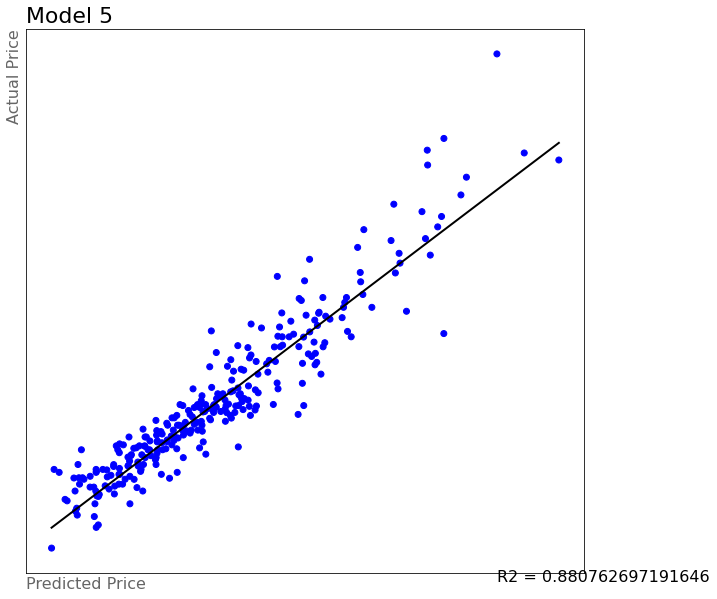

In [176]:
plt.figure(figsize=(10,10))
col = np.where(linreg.predict(x5_scaled_test) > 500000, 'r', 'b')
plt.scatter(linreg.predict(x5_scaled_test), y5_test, c=col)
plt.title('Model 5', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(linreg.predict(x5_scaled_test)), max(linreg.predict(x5_scaled_test))], [min(linreg.predict(x5_scaled_test)), max(linreg.predict(x5_scaled_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {linreg.score(x5_scaled_test, y5_test)}', size=16)

In [177]:
coef5 = linreg.coef_
header5 = x5_test.columns 
d = {'feature': header5, 'coef': coef5}
df5 = pd.DataFrame(d)
df5

feature          coef
0     TotalSF*OverallQual  48795.723013
1             KitchenQual   7985.111915
2              GarageCars   6099.868985
3              TotalBaths   7417.092922
4      Neighborhood_SWISU  -1310.418009
5    Neighborhood_SawyerW  -1023.706300
6    Neighborhood_Veenker   1492.146417
7     Neighborhood_Sawyer    185.346983
8    Neighborhood_StoneBr   2725.741083
9     Neighborhood_NWAmes  -1487.950531
10   Neighborhood_Blmngtn  -2737.212791
11   Neighborhood_NridgHt   3588.704929
12   Neighborhood_MeadowV  -2030.445496
13   Neighborhood_OldTown  -4757.539232
14    Neighborhood_BrDale  -2001.965721
15   Neighborhood_NoRidge   3296.488753
16   Neighborhood_ClearCr   2140.473346
17   Neighborhood_Edwards  -2019.123244
18     Neighborhood_NAmes  -1605.505296
19    Neighborhood_Timber   -149.620757
20   Neighborhood_Gilbert   -227.787194
21   Neighborhood_Blueste   -662.203881
22   Neighborhood_NPkVill  -1401.445669
23   Neighborhood_Crawfor   3533.806907
24   Neighborhood_Mitchel   -692.992591
25   Neighborhood_CollgCr  -1999.933462
26    Neighborhood_IDOTRR  -1666.005067
27   Neighborhood_Somerst  -2184.699680
28  SaleCondition_Abnorml  -3824.151985
29  SaleCondition_AdjLand     11.697435
30   SaleCondition_Family  -1286.880039
31   SaleCondition_Alloca   -220.081435
32  SaleCondition_Partial  -4820.535986
33            SaleType_WD  -7753.101606
34           SaleType_COD  -5760.868888
35         SaleType_ConLI  -2198.996610
36           SaleType_Con    278.237624
37         SaleType_ConLD  -1325.895346
38         SaleType_ConLw  -1800.097029
39           SaleType_CWD  -1068.726245
40           SaleType_New   6129.900501
41               MoSold_2  -1470.410140
42               MoSold_3  -1019.091281
43               MoSold_4  -1320.230204
44               MoSold_5    -10.819408
45               MoSold_6  -1113.881302
46               MoSold_7   -350.257569
47               MoSold_8  -1340.902231
48               MoSold_9  -1303.393066
49              MoSold_10  -1470.097487
50              MoSold_11  -1433.720054
51              MoSold_12  -1125.868327
52            YrSold_2007   -757.930057
53            YrSold_2008    957.893173
54            YrSold_2009    403.993947
55            YrSold_2010    529.048159

Model 5, with the added external factors surprisingly doesn't seem to be overfit. We may want to do additional feature engineering or investigate additional interaction terms.

In [178]:
# Kaggle Predictions - Model 5:
# x_holdout5 = df_test[features5]
# x_scaled_holdout5 = scaler.transform(x_holdout5)
# preds5 = linreg.predict(x_scaled_holdout5)
# submission5 = pd.DataFrame(preds5, index=df_test['Id'])
# submission5.rename(columns={0:'SalePrice'}, inplace=True)
# submission5.head()

In [179]:
# submission5.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission5_scaled.csv')

Model 5 Kaggle Score: 0.16404 Scaled: 0.16301

###### Initial Thoughts and Observations
<br>

Although model 1 provided a quick and decent model for house price based solely off TotalSF, model 2 provided a significantly better r-squared. Multiple Linear Regression provided an even better fit overall, and I believed that utilizing dummy variables for neighborhood would provide the best model given attributes of the house alone can only help predict the prices so much, and the added complexity of location would help. I tried running models both scaled and unscaled, and seems like scaled provides a more interpratable model, as well as slightly improving on the Kaggle scores.

I was surprised that adding in external factors such as SaleType, SaleCond, YrSold, and MoSold did not cause the model to overfit, although once scaled it did not perform as well as model 4 scaled. I do think that additional features can be added into the model for added complexity, which might better the scores slightly, but can definitely benefit from regularization.

##### Model 6 - Ridge Regression

In [180]:
features6 = features5
x6 = df_train[features6]
x6_train, x6_test, y6_train, y6_test = train_test_split(x6, y, test_size=0.2)

In [181]:
scaler = StandardScaler()
x6_scaled_train = scaler.fit_transform(x6_train)
x6_scaled_test = scaler.transform(x6_test)

r_alphas = np.logspace(-5, 5, 200)
ridge = RidgeCV(alphas=r_alphas, store_cv_values=True)

scores = cross_val_score(ridge, x6_scaled_train, y6_train)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.86752631 0.86090368 0.8767185  0.88495446 0.86851454]
Mean: 0.8717234990294417 SD: 0.008306510528590924


In [182]:
ridge.fit(x6_scaled_train, y6_train)
ridge.score(x6_scaled_train, y6_train)

0.8878757566740842

In [183]:
ridge.alpha_

15.167168884709241

In [184]:
ridge.score(x6_scaled_test, y6_test)

0.8938766973631607

Text(400000, 0, 'R2 = 0.8938766973631607')

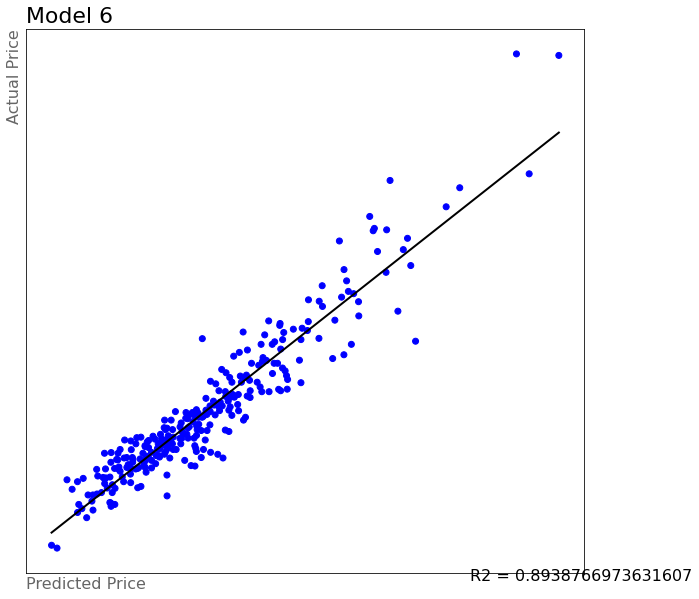

In [185]:
plt.figure(figsize=(10,10))
col = np.where(ridge.predict(x6_scaled_test) > 500000, 'r', 'b')
plt.scatter(ridge.predict(x6_scaled_test), y6_test, c=col)
plt.title('Model 6', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(ridge.predict(x6_scaled_test)), max(ridge.predict(x6_scaled_test))], [min(ridge.predict(x6_scaled_test)), max(ridge.predict(x6_scaled_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {ridge.score(x6_scaled_test, y6_test)}', size=16)

In [186]:
coef_6 = abs(ridge.coef_)
coef_6 = pd.DataFrame(coef_6, index = x6_train.columns)
coef_6 = coef_6.sort_values(0, ascending = False)
coef_6.head(10)

0
TotalSF*OverallQual   47586.177762
KitchenQual            7849.296769
TotalBaths             7841.320670
GarageCars             6617.794383
SaleType_WD            5296.153785
Neighborhood_NridgHt   5014.464301
Neighborhood_NoRidge   4481.083480
Neighborhood_Crawfor   4319.363474
SaleType_New           4049.449239
Neighborhood_OldTown   3927.393089

In [187]:
# # Kaggle Predictions - Model 6:
# x_holdout6 = df_test[features6]
# x_scaled_holdout6 = scaler.transform(x_holdout6)
# preds6 = ridge.predict(x_scaled_holdout6)
# submission6 = pd.DataFrame(preds6, index=df_test['Id'])
# submission6.rename(columns={0:'SalePrice'}, inplace=True)
# submission6.head()

In [188]:
# submission6.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission6_scaled.csv')

Model 6 Kaggle Score: 0.16278

This model is an improvement over standard linear regression given the L2 penalties. Since we're not passing in an absurd amount of features I would have expected an improvement from the previous models.

##### Model 7 - Ridge Regression: All In

In [189]:
dummies = [col for col in df_train.columns if '_' in col]
features7_1 = ['TotalSF*OverallQual', 'KitchenQual', 'GarageCars', 'TotalBaths']
features7 = dummies + features7_1
x7 = df_train[features7]
x7_train, x7_test, y7_train, y7_test = train_test_split(x7, y, test_size=0.2)

In [190]:
scaler = StandardScaler()
x7_scaled_train = scaler.fit_transform(x7_train)
x7_scaled_test = scaler.transform(x7_test)

r_alphas = np.logspace(-5, 5, 200)
ridge = RidgeCV(alphas=r_alphas, store_cv_values=True)

scores = cross_val_score(ridge, x7_scaled_train, y7_train)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.88105618 0.88004277 0.88299255 0.88143464 0.90086096]
Mean: 0.8852774188053804 SD: 0.007849264934623797


In [191]:
ridge.fit(x7_scaled_train, y7_train)
ridge.score(x7_scaled_train, y7_train)

0.9219727350394373

In [192]:
ridge.alpha_

19.116440753857038

In [193]:
ridge.score(x7_scaled_test, y7_test)

0.8776286190347358

Text(400000, 0, 'R2 = 0.8776286190347358')

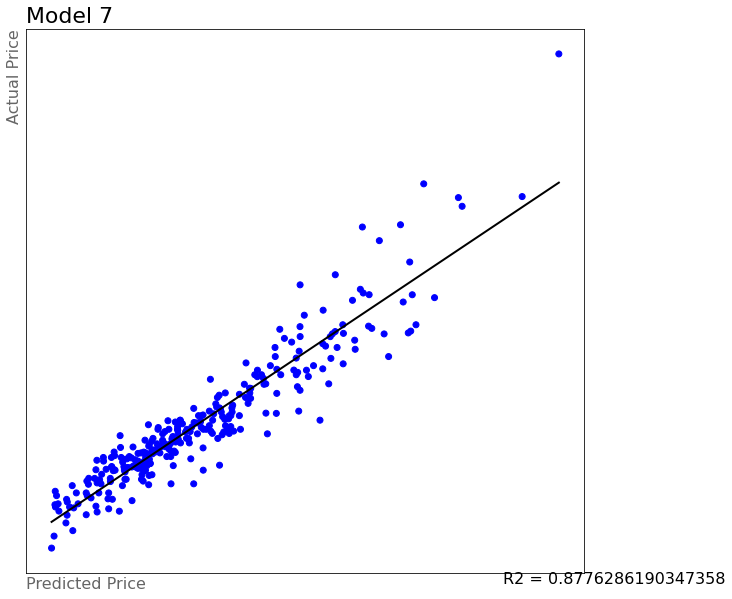

In [194]:
plt.figure(figsize=(10,10))
col = np.where(ridge.predict(x7_scaled_test) > 500000, 'r', 'b')
plt.scatter(ridge.predict(x7_scaled_test), y7_test, c=col)
plt.title('Model 7', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(ridge.predict(x7_scaled_test)), max(ridge.predict(x7_scaled_test))], [min(ridge.predict(x7_scaled_test)), max(ridge.predict(x7_scaled_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {ridge.score(x7_scaled_test, y7_test)}', size=16)

In [195]:
coef_7 = abs(ridge.coef_)
coef_7 = pd.DataFrame(coef_7, index = x7_train.columns)
coef_7 = coef_7.sort_values(0, ascending = False)
coef_7.head(10)

0
TotalSF*OverallQual  43652.380159
BsmtFinType1_Unf      7462.136562
MSSubClass_60         6629.174531
GarageCars            6544.310511
KitchenQual           6461.165460
BsmtFinType2_NA       5920.026790
BsmtFinType1_NA       5863.669201
BldgType_1Fam         5304.381685
TotalBaths            5198.352335
SaleType_New          4554.727456

In [196]:
# # Kaggle Predictions - Model 7:
# x_holdout7 = df_test[features7]
# x_scaled_holdout7 = scaler.transform(x_holdout7)
# preds7 = ridge.predict(x_scaled_holdout7)
# submission7 = pd.DataFrame(preds7, index=df_test['Id'])
# submission7.rename(columns={0:'SalePrice'}, inplace=True)
# submission7.head()

In [197]:
# submission7.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission7_scaled.csv')

Model 7 Kaggle Score: 0.15720

Surprisingly even though it seems quite overfit with the variance between train and test scores, it performed well from a Kaggle scoring perspective. 

##### Model 8 - Lasso Regression

In [198]:
features8 = features6
x8 = df_train[features8]
x8_train, x8_test, y8_train, y8_test = train_test_split(x8, y, test_size=0.2)

In [199]:
scaler = StandardScaler()
x8_scaled_train = scaler.fit_transform(x8_train)
x8_scaled_test = scaler.transform(x8_test)

l_alphas = np.logspace(-6, 6, 360)
lasso = LassoCV(n_alphas=1000, alphas=l_alphas, max_iter=10000)

scores = cross_val_score(lasso, x8_scaled_train, y8_train)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.85612689 0.89815844 0.89777152 0.86456522 0.85576624]
Mean: 0.8744776612407318 SD: 0.019434544800143935


In [200]:
lasso.fit(x8_scaled_train, y8_train)
lasso.score(x8_scaled_train, y8_train)

0.8868166630157395

In [201]:
lasso.alpha_

618.1392928452677

In [202]:
lasso.score(x8_scaled_test, y8_test)

0.889534329002111

Text(400000, 0, 'R2 = 0.889534329002111')

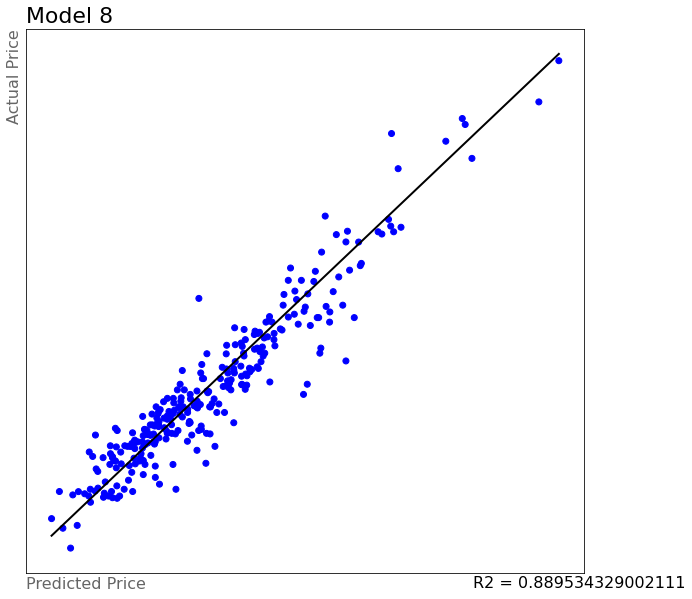

In [203]:
plt.figure(figsize=(10,10))
col = np.where(lasso.predict(x8_scaled_test) > 500000, 'r', 'b')
plt.scatter(lasso.predict(x8_scaled_test), y8_test, c=col)
plt.title('Model 8', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(lasso.predict(x8_scaled_test)), max(lasso.predict(x8_scaled_test))], [min(lasso.predict(x8_scaled_test)), max(lasso.predict(x8_scaled_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {lasso.score(x8_scaled_test, y8_test)}', size=16)

In [204]:
coef_8 = abs(lasso.coef_)
coef_8 = pd.DataFrame(coef_8, index = x8_train.columns)
coef_8 = coef_8.sort_values(0, ascending = False)
coef_8.head(10)

0
TotalSF*OverallQual    51434.143742
TotalBaths              8401.426244
KitchenQual             6558.633304
SaleType_New            6253.965002
GarageCars              5249.194840
Neighborhood_StoneBr    4523.592926
Neighborhood_Crawfor    4383.962702
Neighborhood_NridgHt    4264.121167
SaleCondition_Abnorml   3131.638583
Neighborhood_NoRidge    2967.919950

In [205]:
# # Kaggle Predictions - Model 8:
# x_holdout8 = df_test[features8]
# x_scaled_holdout8 = scaler.transform(x_holdout8)
# preds8 = lasso.predict(x_scaled_holdout8)
# submission8 = pd.DataFrame(preds8, index=df_test['Id'])
# submission8.rename(columns={0:'SalePrice'}, inplace=True)
# submission8.head()

In [206]:
# submission8.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission8_scaled.csv')

According to the cross validation and the variance between train and test scores, it seems like this model is fit quite well, and I would expect it to perform well with new unseen data. 

Model 8 Kaggle Score: 0.15754

I was quite surprised that it did not perform as well, as compared to the previous model, which seemed to be overfit.

##### Model 9 - Lasso Regression: All In

In [207]:
features9 = features7
x9 = df_train[features9]
x9_train, x9_test, y9_train, y9_test = train_test_split(x9, y, test_size=0.2)

In [208]:
%%time
scaler = StandardScaler()
x9_scaled_train = scaler.fit_transform(x9_train)
x9_scaled_test = scaler.transform(x9_test)

l_alphas = np.logspace(-6, 6, 600)
lasso = LassoCV(n_alphas=1500, alphas=l_alphas, max_iter=15000)

scores = cross_val_score(lasso, x9_scaled_train, y9_train)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

[0.90938845 0.89048622 0.88558637 0.89993282 0.89060671]
Mean: 0.8952001120909641 SD: 0.00847881761519995
CPU times: user 2min 5s, sys: 1min 37s, total: 3min 43s
Wall time: 1min 54s


In [209]:
lasso.fit(x9_scaled_train, y9_train)
lasso.score(x9_scaled_train, y9_train)

0.9190655372164143

In [210]:
lasso.alpha_

623.243507363086

In [211]:
lasso.score(x9_scaled_test, y9_test)

0.8658242431386786

Text(400000, 0, 'R2 = 0.8658242431386786')

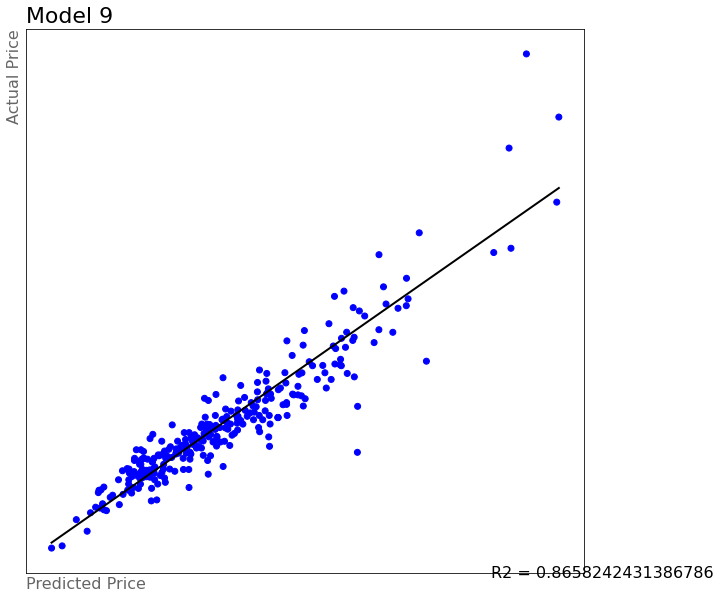

In [212]:
plt.figure(figsize=(10,10))
col = np.where(lasso.predict(x9_scaled_test) > 500000, 'r', 'b')
plt.scatter(lasso.predict(x9_scaled_test), y9_test, c=col)
plt.title('Model 9', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(lasso.predict(x9_scaled_test)), max(lasso.predict(x9_scaled_test))], [min(lasso.predict(x9_scaled_test)), max(lasso.predict(x9_scaled_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {lasso.score(x9_scaled_test, y9_test)}', size=16)

In [213]:
coef_9 = abs(lasso.coef_)
coef_9 = pd.DataFrame(coef_9, index = x9_train.columns)
coef_9 = coef_9.sort_values(0, ascending = False)
coef_9.head(10)

0
TotalSF*OverallQual   48166.193893
SaleType_New           6165.739701
BldgType_1Fam          5982.375394
KitchenQual            5804.922422
TotalBaths             5358.960944
GarageCars             5179.094674
Neighborhood_Crawfor   5052.092782
neighborhoodcat_3      4947.628371
BsmtFinType1_Unf       4674.995389
Neighborhood_NridgHt   3604.967957

In [214]:
# # Kaggle Predictions - Model 9:
# x_holdout9 = df_test[features9]
# x_scaled_holdout9 = scaler.transform(x_holdout9)
# preds9 = lasso.predict(x_scaled_holdout9)
# submission9 = pd.DataFrame(preds9, index=df_test['Id'])
# submission9.rename(columns={0:'SalePrice'}, inplace=True)
# submission9.head()

In [215]:
# submission9.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission9_scaled2.csv')

In [216]:
eli5.show_weights(lasso)

In [217]:
# Feature Importance eli5
print(x9_train.columns[159])
print(x9_train.columns[160])
print(x9_train.columns[162])
print(x9_train.columns[58])
print(x9_train.columns[23])

TotalSF*OverallQual
KitchenQual
TotalBaths
BldgType_TwnhsE
Neighborhood_Somerst


Model 9 Kaggle Score: 0.14866

Again, the cross validation makes this model seem as though it would perform quite well, but shows a high variance between train and test scores. It turns out that this model performed the best so far. 

I also tried to utilize the eli5 package to see if it would provide additional interpretability for the model, but seems to line up perfectly with the model coefficients for the model for feature importance.



##### Model 10 - ElasticNet: Mix it up

In [218]:
features10 = features9
x10 = df_train[features10]
x10_train, x10_test, y10_train, y10_test = train_test_split(x10, y, test_size=0.2)

In [219]:
%%time
scaler = StandardScaler()
x10_scaled_train = scaler.fit_transform(x10_train)
x10_scaled_test = scaler.transform(x10_test)

enet_alphas = np.logspace(0, 6, 150)
enet_ratios = np.arange(0, 1, 0.1)
enet = ElasticNetCV(n_alphas=200, alphas=enet_alphas, l1_ratio=enet_ratios, cv=7, max_iter=1000)

scores = cross_val_score(enet, x10_scaled_train, y10_train)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

Streaming output truncated to the last 5000 lines.
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2275497904770.063, tolerance: 455385749.1876606
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2275359012549.111, tolerance: 455385749.1876606
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2275206651095.31, tolerance: 455385749.1876606
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2275039516876.196, tolerance: 455385749.1876606
Coordinate descent with alpha=0 may lead to unexpe

[0.90216233 0.9005928  0.86225928 0.88234244 0.8438032 ]
Mean: 0.8782320087858746 SD: 0.02249458587127938
CPU times: user 3min 16s, sys: 2min 30s, total: 5min 46s
Wall time: 3min 5s


In [220]:
enet.fit(x10_scaled_train, y10_train)
enet.score(x10_scaled_train, y10_train)

Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2816169409297.542, tolerance: 563237251.2714708
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2816167772515.3506, tolerance: 563237251.2714708
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2816165976712.4746, tolerance: 563237251.2714708
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2816164006439.6475, tolerance: 563237251.2714708
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did 

0.9115722555141628

In [221]:
optimal_alpha = enet.alpha_
optimal_ratio = enet.l1_ratio_

In [222]:
optimal_alpha

1.0

In [223]:
optimal_ratio

0.9

In [224]:
enet.score(x10_scaled_test, y10_test)

0.8788639220414296

Text(400000, 0, 'R2 = 0.8788639220414296')

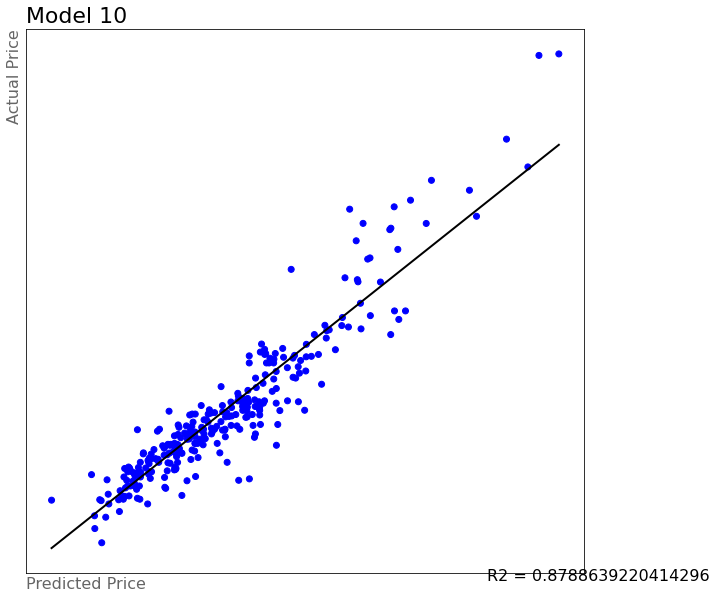

In [225]:
plt.figure(figsize=(10,10))
col = np.where(enet.predict(x10_scaled_test) > 500000, 'r', 'b')
plt.scatter(enet.predict(x10_scaled_test), y10_test, c=col)
plt.title('Model 10', position=(0,1), size=22, ha='left')
plt.xlabel('Predicted Price', position=(0,0), size=16, alpha=0.6, ha='left')
plt.ylabel('Actual Price', position=(0,1), size=16, alpha=0.6, ha='right')
plt.yticks([])
plt.xticks([])
plt.plot([min(enet.predict(x10_scaled_test)), max(enet.predict(x10_scaled_test))], [min(enet.predict(x10_scaled_test)), max(enet.predict(x10_scaled_test))], 'k-', lw=2)
ax = plt.gca()
ax.text(400000, 0, f'R2 = {enet.score(x10_scaled_test, y10_test)}', size=16)

In [226]:
coef_10 = abs(enet.coef_)
coef_10 = pd.DataFrame(coef_10, index = x10_train.columns)
coef_10 = coef_10.sort_values(0, ascending = False)
coef_10.head(10)

0
TotalSF*OverallQual   31531.347128
KitchenQual            7594.351170
TotalBaths             7528.946656
GarageCars             7222.830953
BsmtFinType1_Unf       5210.304100
BldgType_1Fam          4917.681841
TotRmsAbvGrd_12        4660.570442
Neighborhood_NridgHt   4627.769300
neighborhoodcat_3      4399.729086
TotRmsAbvGrd_11        3838.459899

In [227]:
# # Kaggle Predictions - Model 10:
# x_holdout10 = df_test[features10]
# x_scaled_holdout10 = scaler.transform(x_holdout10)
# preds10 = enet.predict(x_scaled_holdout10)
# submission10 = pd.DataFrame(preds10, index=df_test['Id'])
# submission10.rename(columns={0:'SalePrice'}, inplace=True)
# submission10.head()

In [228]:
# submission10.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/submission10_scaled2.csv')

In [229]:
eli5.show_weights(enet)

In [230]:
print(x9_train.columns[159])
print(x9_train.columns[161])
print(x9_train.columns[162])
print(x9_train.columns[160])
print(x9_train.columns[23])

TotalSF*OverallQual
GarageCars
TotalBaths
KitchenQual
Neighborhood_Somerst


For some reason, I couldn't get the Elastic Net model to converge even with different configurations. It would be due to the complexity and high dimensionality of the data. 

Second Try:

In [231]:
features10 = features8
x10 = df_train[features10]
x10_train, x10_test, y10_train, y10_test = train_test_split(x10, y, test_size=0.2)

In [232]:
%%time
scaler = StandardScaler()
x10_scaled_train = scaler.fit_transform(x10_train)
x10_scaled_test = scaler.transform(x10_test)

enet_alphas = np.logspace(0, 6, 150)
enet_ratios = np.arange(0, 1, 0.1)
enet = ElasticNetCV(n_alphas=200, alphas=enet_alphas, l1_ratio=enet_ratios, cv=7, max_iter=1000)

scores = cross_val_score(enet, x10_scaled_train, y10_train)
print(scores)
print(f'Mean: {scores.mean()} SD: {scores.std()}')

Streaming output truncated to the last 5000 lines.
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2311040081726.1094, tolerance: 462368039.7154919
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2310962381567.445, tolerance: 462368039.7154919
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2310877139718.094, tolerance: 462368039.7154919
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2310783624954.6104, tolerance: 462368039.7154919
Coordinate descent with alpha=0 may lead to une

[0.89194474 0.90072897 0.85666867 0.85835133 0.88477028]
Mean: 0.8784927989639207 SD: 0.01787053275680193
CPU times: user 42.1 s, sys: 11.8 s, total: 54 s
Wall time: 39.1 s


In [233]:
enet.fit(x10_scaled_train, y10_train)
enet.score(x10_scaled_train, y10_train)

Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2986365372179.8345, tolerance: 597274944.5333775
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2986364463726.1733, tolerance: 597274944.5333775
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2986363467011.435, tolerance: 597274944.5333775
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2986362373460.6753, tolerance: 597274944.5333775
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did 

0.8883195836511443

In [234]:
optimal_alpha = enet.alpha_
optimal_ratio = enet.l1_ratio_
print(optimal_alpha)
print(optimal_ratio)

1.0
0.9


In [235]:
enet.score(x10_scaled_test, y10_test)

0.8630715631498739

Even with the same features as model 8, the Elastic Net model does not seem to converge. I will need to tinker with this a bit more.

I suspect once converged that the Elastic Net model should perform the best given its use of both L1 and L2 penalties.